## High-level Overview
*Event-driven stock rally prediction using 8K SEC Filings. Predict the movement of a stock on the (t+5) day following an 8K Filing.*

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import math
import time
import shap

from pandas_datareader.data import DataReader
from copy import deepcopy
from nltk import FreqDist
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from collections import Counter, defaultdict
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from textblob import TextBlob

from os.path import isdir, join, isfile
from matplotlib.colors import DivergingNorm
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix, 
                             roc_curve, 
                             auc, 
                             matthews_corrcoef,
                             roc_auc_score
                            )
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from scipy.sparse import hstack
from xgboost import XGBClassifier
import xgboost as xgb

#sns.set_style(style="whitegrid")
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import concatenate as lconcat
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from keras.backend.tensorflow_backend import set_session

In [4]:
import plotly.offline as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)

In [5]:
# This dictionary defines the colormap
cdict = {'green':  ((0.0, 0.0, 0.0),   
                    (0.5, 1.0, 1.0),   
                    (1.0, 0.8, 0.8)),  

        'red': ((0.0, 0.8, 0.8),   
                (0.5, 1.0, 1.0),   
                (1.0, 0.0, 0.0)),  

        'blue':  ((0.0, 0.0, 0.0),   
                  (0.5, 1.0, 1.0),   
                  (1.0, 0.0, 0.0))   
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

## 1. Read all Text Processed Files

Combined text processed 8K SEC files across all 30 DJIA companies, with a period from 2010-01-01 to 2019-12-31. 

In [6]:
path = "../../Processed Data/8K SEC"

In [7]:
files = [f for f in os.listdir(path) if isfile(join(path, f))]
files = [i for i in files if i not in [".DS_Store"]]

In [8]:
dfs = []
for file in files:
    df = pd.read_pickle(path+"/"+file)
    dfs.append(df)

In [9]:
final_df = pd.concat(dfs)


In [10]:
final_df = final_df.reset_index().drop("index", axis=1)

In [11]:
cols = ["ticker", "security", "cik", "sector", "date"]

In [12]:
final_df = final_df[cols + [i for i in final_df.columns if i not in cols]]

### 1.1 Inspect Data Quality
- Remove rows with missing documents

In [13]:
final_df["doc_length"] = final_df["processed_text_lemm"].map(len) 

In [14]:
final_df[final_df.doc_length == 0]

ticker              security      cik                  sector       date  \
173      GS   Goldman Sachs Group   886982              Financials 2011-03-17   
345      GS   Goldman Sachs Group   886982              Financials 2013-11-14   
1171    WMT               Walmart   104169        Consumer Staples 2018-05-17   
1242    XOM     Exxon Mobil Corp.    34088                  Energy 2014-03-11   
1595     BA        Boeing Company    12927             Industrials 2012-10-17   
1608     BA        Boeing Company    12927             Industrials 2013-10-31   
2775    UTX   United Technologies   101829             Industrials 2011-11-14   
3235    JPM  JPMorgan Chase & Co.    19617              Financials 2013-03-08   
3430    JPM  JPMorgan Chase & Co.    19617              Financials 2019-06-21   
4037    AXP   American Express Co     4962              Financials 2010-04-28   
4527      V             Visa Inc.  1403161  Information Technology 2011-05-11   
4544      V             Visa Inc.  1403161  Information Technology 2012-05-02   
4625      V             Visa Inc.  1403161  Information Technology 2017-02-02   

     processed_text_lemm processed_text_stem  \
173                   []                  []   
345                   []                  []   
1171                  []                  []   
1242                  []                  []   
1595                  []                  []   
1608                  []                  []   
2775                  []                  []   
3235                  []                  []   
3430                  []                  []   
4037                  []                  []   
4527                  []                  []   
4544                  []                  []   
4625                  []                  []   

                                              directory  \
173   ../../Raw Data/8K SEC/886982/886982_2011-03-18...   
345   ../../Raw Data/8K SEC/886982/886982_2013-11-15...   
1171  ../../Raw Data/8K SEC/104169/104169_2018-05-17...   
1242   ../../Raw Data/8K SEC/34088/34088_2014-03-11.txt   
1595   ../../Raw Data/8K SEC/12927/12927_2012-10-17.txt   
1608   ../../Raw Data/8K SEC/12927/12927_2013-10-31.txt   
2775  ../../Raw Data/8K SEC/101829/101829_2011-11-15...   
3235   ../../Raw Data/8K SEC/19617/19617_2013-03-08.txt   
3430   ../../Raw Data/8K SEC/19617/19617_2019-06-21.txt   
4037     ../../Raw Data/8K SEC/4962/4962_2010-04-28.txt   
4527  ../../Raw Data/8K SEC/1403161/1403161_2011-05-...   
4544  ../../Raw Data/8K SEC/1403161/1403161_2012-05-...   
4625  ../../Raw Data/8K SEC/1403161/1403161_2017-02-...   

                                                   text  \
173   0000950123-11-026482.txt : 20110318 0000950123...   
345   0001193125-13-442689.txt : 20131115 0001193125...   
1171  earningspresentation0430 Safe harbor and non-G...   
1242  FREQUENTLY USED TERMS AND ADDITIONAL INFORMATI...   
1595  0000012927-12-000019.txt : 20121017 0000012927...   
1608  0000012927-13-000044.txt : 20131031 0000012927...   
2775  0001193125-11-311555.txt : 20111115 0001193125...   
3235  jpmc2013ccarexhibit992 March 7, 2013 2 0 1 3 A...   
3430  a2019ccardfastresults062 2019 Annual Stress Te...   
4037  ex99_2.htm American Express Earnings Conferenc...   
4527  Visa Inc. Presentation Visa’s Global Innovatio...   
4544  Presentation of Visa Inc. Visa Inc. Fiscal Sec...   
4625  vex992123116earningspres Visa Inc. Fiscal Firs...   

                                                  items  ... signal_20  \
173   [Departure of Directors or Certain Officers; E...  ...        up   
345                                      [Other Events]  ...        up   
1171  [Results of Operations and Financial Condition...  ...        up   
1242  [Results of Operations and Financial Condition...  ...        up   
1595  [Entry into a Material Definitive Agreement, C...  ...      down   
1608  [Entry into a Material Definitive Agreement, C...  ...        up   
2775  [Entry into a Mater

In [15]:
final_df = final_df[final_df.doc_length > 0]

In [16]:
len(final_df)

4651

### 1.2 Remove DOW, WBA, DIS, TRV, CAT
- because historical period is not long enough and poor data quality from other textual data sources

In [17]:
final_df = final_df[~final_df.ticker.isin(["DOW", "WBA", "DIS", "TRV", "CAT"])]

## 2. Split into Train and Unseen Test Set

- Train Period: 2010-01-01 - 2017-12-31
- Test Period: 2018-01-01 - 2019-12-31


In [18]:
tickers = list(final_df.ticker.unique())

In [19]:
train_dfs = []
test_dfs = []
for ticker in tickers:
    sub_df = final_df[final_df.ticker == ticker]
    train_df = sub_df[(sub_df.date >= "2010-01-01") & (sub_df.date <= "2017-12-31")]
    test_df = sub_df[(sub_df.date >= "2018-01-01") & (sub_df.date <= "2019-12-31")]
    
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [20]:
in_sample_df = pd.concat(train_dfs)
out_sample_df = pd.concat(test_dfs)


In [21]:
in_sample_df = in_sample_df.reset_index().drop("index", axis=1)

In [22]:
out_sample_df = out_sample_df.reset_index().drop("index", axis=1)

## 3. Exploratory Data Analysis

### 3.1 Sanity Check of the Frequency of Words (Lemmatized and Stemmed)


This is used as a proxy for any "meaningliness" or "gibberish" words. The check is done multiple times, and for each iteration, new stopwords are added to the text-processing phase (**cleaning.py**) until the most frequent words are cleaned. 

In [23]:
# function to plot most frequent terms
def freq_words(x, title, terms = 30):
    '''
    Function to plot most frequent terms
    Args:
      x: A list of tokens
      title: A string; title of plot
      terms: An integer; The top number of tokens in terms of frequency
    Returns:
      Frequency bar chart
    '''
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.title(title)
    plt.show()

In [24]:
in_sample_df['joined_text_lemm'] = in_sample_df.processed_text_lemm.map(lambda x : " ".join(x))
in_sample_df['joined_text_stem'] = in_sample_df.processed_text_stem.map(lambda x : " ".join(x))

In [25]:
out_sample_df['joined_text_lemm'] = out_sample_df.processed_text_lemm.map(lambda x : " ".join(x))
out_sample_df['joined_text_stem'] = out_sample_df.processed_text_stem.map(lambda x : " ".join(x))

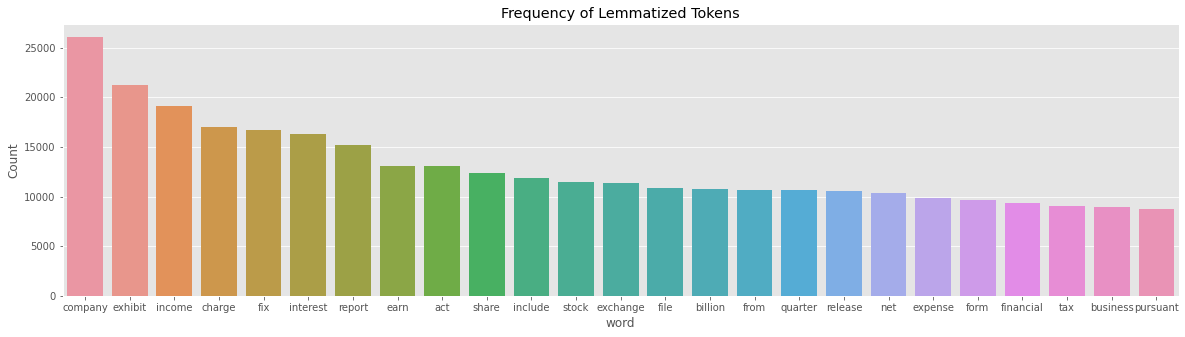

In [26]:
freq_words(in_sample_df["joined_text_lemm"], "Frequency of Lemmatized Tokens", 25)

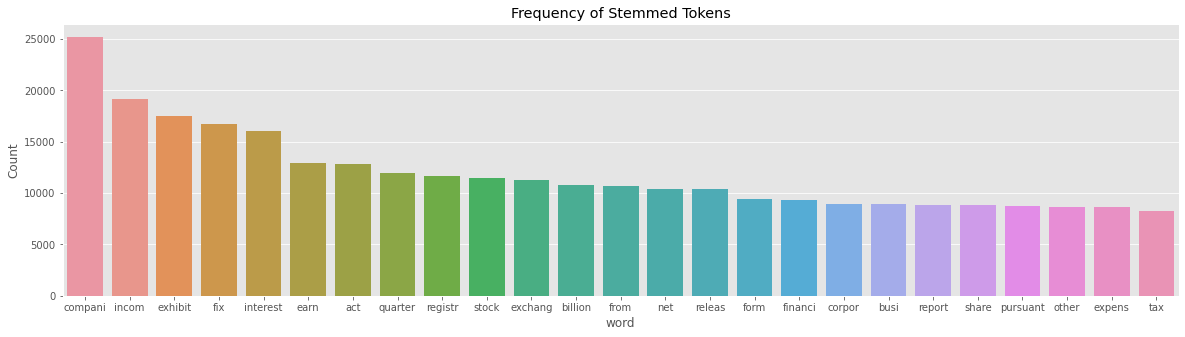

In [27]:
freq_words(in_sample_df["joined_text_stem"], "Frequency of Stemmed Tokens", 25)

**Observation:** Generally, we can see that the words in the corpus are generally clean and have some meaning or value to it. Nonetheless, we should also note that the frequency of the words do not necessarily translate to the importance of the words. This is more of a check for a "clean" corpus.

In [28]:
out_sample_df.columns == in_sample_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

### 3.2 Distribution of GICS Sector

For this section, we looked at the proportion of GICS Sector in the DJIA Stocks basket. Additionally, we recognised that across all 8K SEC Filings, there are different event/item types (e.g. *Corporate Governance, Financial Statements, Regulation etc*). Hence, we drilled the analysis further into specific 8K event. 

In [29]:
cik_mapper = pd.read_csv("cik_mapper.csv")

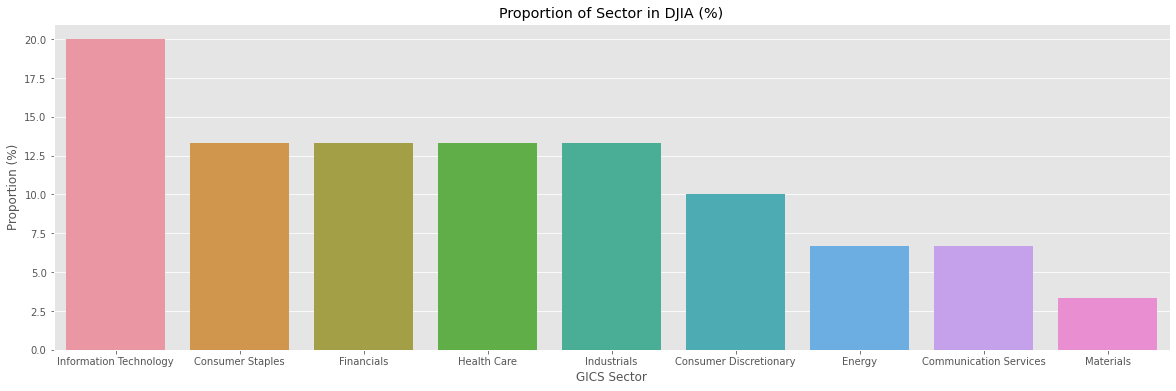

In [30]:
sector_count = pd.DataFrame(cik_mapper["GICS Sector"].value_counts()).reset_index()
sector_count = sector_count.rename(columns = {"index": "GICS Sector", "GICS Sector": "Count"})
sector_count["Proportion"] = sector_count.Count / 30 * 100
plt.figure(figsize=(20,6))

ax = sns.barplot(x = "GICS Sector", y = "Proportion", data = sector_count)
plt.title("Proportion of Sector in DJIA (%)")
plt.ylabel("Proportion (%)")
plt.show()

**Observation:** The DJIA overweights on Information Tech. Equally distributed across Financials Consumer Staples, Industrials and Health Care. 

In [31]:
cik_mapper[cik_mapper.Symbol.isin(["AAPL", "CSCO", "KO", "MSFT", "NKE", "PFE", "UNH", "UTX", "V"])]

Unnamed: 0 Symbol                  Security SEC filings  \
2            2   AAPL                Apple Inc.     reports   
6            6   CSCO             Cisco Systems     reports   
7            7     KO         Coca-Cola Company     reports   
18          18   MSFT           Microsoft Corp.     reports   
19          19    NKE                      Nike     reports   
20          20    PFE               Pfizer Inc.     reports   
23          23    UNH  United Health Group Inc.     reports   
24          24    UTX       United Technologies     reports   
26          26      V                 Visa Inc.     reports   

               GICS Sector       GICS Sub Industry      Headquarters Location  \
2   Information Technology  Information Technology      Cupertino, California   
6   Information Technology  Information Technology       San Jose, California   
7         Consumer Staples        Consumer Staples           Atlanta, Georgia   
18  Information Technology  Information Technology        Redmond, Washington   
19  Consumer Discretionary  Consumer Discretionary  Washington County, Oregon   
20             Health Care             Health Care         New York, New York   
23             Health Care             Health Care      Minnetonka, Minnesota   
24             Industrials             Industrials      Hartford, Connecticut   
26  Information Technology  Information Technology  San Francisco, California   

   Date first added      CIK  Founded  
2        1982-11-30   320193   1977.0  
6        1993-12-01   858877      NaN  
7               NaN    21344   1886.0  
18       1994-06-01   789019   1975.0  
19       1988-11-30   320187      NaN  
20              NaN    78003   1849.0  
23       1994-07-01   731766      NaN  
24              NaN   101829      NaN  
26       2009-12-21  1403161      NaN

### 3.3 Distribution of 8K Event Types

Events: 
- Registrant's Business and Operations;
- Financial Information; 
- Securities and Trading Markets;
- Matters Related to Accountants and Financial Statements; 
- Corporate Governance and Management; 
- Asset-Backed Securities; 
- Regulation FD; 
- Other Events; 
- Financial Statements and Exhibits

We will defer the elaboration of each event to the following site: https://www.sec.gov/fast-answers/answersform8khtm.html

#### 3.3.1 Basic Breakdown of Event Types

In [32]:
all_events = ["Registrant's Business and Operations",
              "Financial Information",
              "Securities and Trading Markets",
              "Matters Related to Accountants and Financial Statements",
              "Corporate Governance and Management",
              "Asset-Backed Securities",
              "Regulation FD",
              "Other Events",
              "Financial Statements and Exhibits"
             ]

In [33]:
short_form = {"Registrant's Business and Operations": "Business & Ops",
              "Financial Information": "Financial Info",
              "Securities and Trading Markets": "Sec & Trading",
              "Matters Related to Accountants and Financial Statements": "Accounts",
              "Corporate Governance and Management": "Corporate Governance",
              "Asset-Backed Securities": "Asset-Backed Sec",
              "Regulation FD": "Regulation FD",
              "Other Events": "Others",
              "Financial Statements and Exhibits": "Fin Statements & Exhibits"
             }

In [34]:
event_count = {}
for event in all_events:
    count = sum(in_sample_df[event])
    event_count[short_form[event]] = count

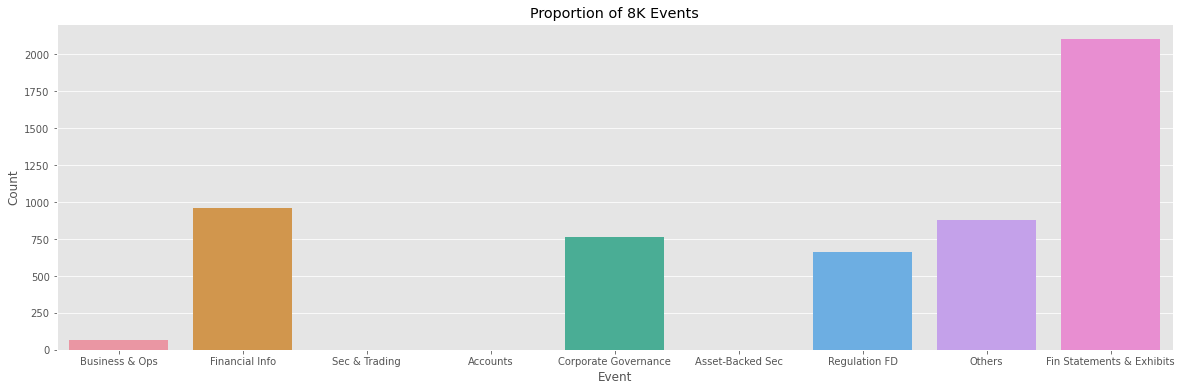

In [35]:
event_count_df = pd.DataFrame([event_count], columns=event_count.keys()).transpose().reset_index()
event_count_df = event_count_df.rename(columns = {"index": "Event", 0:"Count"})

plt.figure(figsize=(20,6))
plot = sns.barplot(x = "Event", y = "Count", data = event_count_df)
plt.title("Proportion of 8K Events")
plt.ylabel("Count")

ax = plot.axes
plt.show()

**Observation:** Most of the events issued under 8K are financial statements. There is an equal distribution of financial information, corporate governance and regulation FD.

#### 3.3.2 Number of Events/Items on each 8K SEC Release

**Key Question**: Is there only one event on the release day? Can there be multiple events on the same day?

In [36]:
specific_events = []
for index, row in in_sample_df.iterrows():
    specific_event = []
    for event in all_events:
        if row[event] == 1:
            specific_event.append(event)
    specific_events.append(specific_event)

In [37]:
in_sample_df["category"] = [sorted(i) for i in specific_events]

In [38]:
in_sample_df["num_events"] = in_sample_df["category"].map(len)

In [39]:
specific_events_test = []
for index, row in out_sample_df.iterrows():
    specific_event = []
    for event in all_events:
        if row[event] == 1:
            specific_event.append(event)
    specific_events_test.append(specific_event)

out_sample_df["category"] = [sorted(i) for i in specific_events_test]

out_sample_df["num_events"] = out_sample_df["category"].map(len)

In [40]:
out_sample_df.columns == in_sample_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

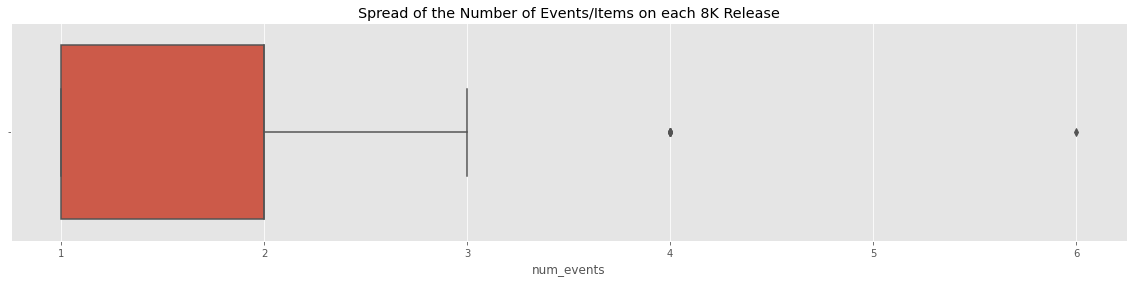

Mean: 1.6820148331273177
25%: 1.0
50%: 2.0
75%: 2.0


In [41]:
plt.figure(figsize=(20,4))
ax = sns.boxplot(in_sample_df.num_events)
plt.title("Spread of the Number of Events/Items on each 8K Release")
plt.show()
print("Mean: {}".format(in_sample_df.num_events.describe()["mean"]))
print("25%: {}".format(in_sample_df.num_events.describe()["25%"]))
print("50%: {}".format(in_sample_df.num_events.describe()["50%"]))
print("75%: {}".format(in_sample_df.num_events.describe()["75%"]))

In [42]:
in_sample_df.category.map(str).unique()

array(["['Financial Information', 'Financial Statements and Exhibits']",
       "['Corporate Governance and Management', 'Financial Statements and Exhibits']",
       "['Financial Statements and Exhibits', 'Other Events']",
       "['Financial Information', 'Financial Statements and Exhibits', 'Regulation FD']",
       "['Other Events']",
       "['Corporate Governance and Management', 'Financial Statements and Exhibits', 'Regulation FD']",
       "['Corporate Governance and Management']",
       "['Corporate Governance and Management', 'Regulation FD']",
       '[\'Financial Information\', \'Financial Statements and Exhibits\', "Registrant\'s Business and Operations"]',
       '[\'Financial Statements and Exhibits\', "Registrant\'s Business and Operations"]',
       "['Financial Statements and Exhibits', 'Regulation FD']",
       '["Registrant\'s Business and Operations"]',
       "['Financial Statements and Exhibits', 'Other Events', 'Regulation FD']",
       "['Financial Information

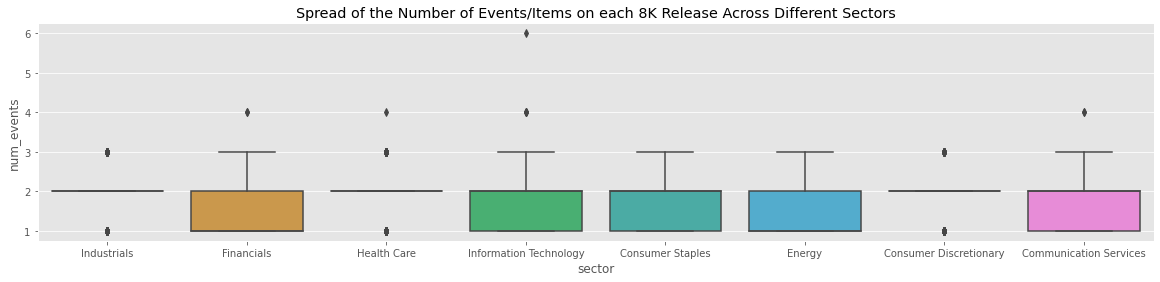

In [43]:
plt.figure(figsize=(20,4))
ax = sns.boxplot(x="sector", y="num_events", data=in_sample_df)
plt.title("Spread of the Number of Events/Items on each 8K Release Across Different Sectors")
plt.show()

**Observation:** Diving deeper, we can see that on each 8K SEC filing release, there can be more than one event/item. E.g. on the release day, the company can issue all 3 events: (1) Corporate Goverannce and Management; (2) Financial Information; (3) Regulation FD

#### 2.3.3 Frequency Distribution and Word Cloud of each 8K Event

For this analysis, we will only look at 8K release days that have a single event. We expect different keywords for each specific event/item.

In [44]:
def keywords(category, tokens = "processed_text_lemm", data=in_sample_df, single_event=False):
    '''
    Extract the keywords of each category
    Args:
      category: A string; event item
      tokens: A string of words; 8-K document
      data: A Pandas `dataframe`
      single_event: Boolean; Indicate whether the 8-K report only has one event item
    Returns:
      A list of the top 10 keywords. Each element is a tuple (keyword, count of keyword)
    '''
    if single_event:
        tokens = data[data["category"] == category][tokens]
    else:
        tokens = data[data[category] == 1][tokens]
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [45]:
sub_df = in_sample_df[in_sample_df.num_events == 1]

In [46]:
sub_df["category"] = sub_df["category"].map(lambda x:x[0])

In [47]:
for category in all_events:
    print('category :', category)
    print('top 10 keywords:', keywords(category, data=sub_df, single_event=True))
    print('---')

category : Registrant's Business and Operations
top 10 keywords: [('agreement', 42), ('company', 40), ('visa', 37), ('act', 26), ('amend', 26), ('transaction', 25), ('pursuant', 23), ('may', 23), ('share', 23), ('exchange', 20)]
---
category : Financial Information
top 10 keywords: [('percent', 4299), ('our', 3237), ('income', 3096), ('revenue', 2964), ('billion', 2890), ('quarter', 2880), ('from', 2810), ('operate', 2802), ('year', 2470), ('business', 2406)]
---
category : Securities and Trading Markets
top 10 keywords: [('act', 9), ('name', 7), ('number', 7), ('exchange', 7), ('corporation', 7), ('file', 6), ('former', 6), ('pursuant', 6), ('company', 5), ('state', 5)]
---
category : Matters Related to Accountants and Financial Statements
top 10 keywords: []
---
category : Corporate Governance and Management
top 10 keywords: [('act', 2075), ('company', 2008), ('vote', 1974), ('exchange', 1597), ('pursuant', 1485), ('file', 1418), ('report', 1377), ('name', 1368), ('number', 1341), ('

In [48]:
def get_freqdist_wc(text, event_type, num_words=30):
    '''
    Function to generate word cloud and frequency term chart
    Args:
      text: A string; 8-K Document
      event_type: A string; event_item
      num_words: An integer; The top number of words in terms of frequency to show on the frequency chart
    Returns:
      A chart comprising of word cloud and frequency chart
    '''
    try: 
        all_words = ' '.join([word for word in text])
        all_words = all_words.split()

        freq_dist = FreqDist(all_words)
        wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)

        plt.figure(figsize=(22,6))
        plt.subplot2grid((1,5),(0,0),colspan=2)
        plt.imshow(wordcloud,interpolation='bilinear')
        plt.axis('off')

        plt.subplot2grid((1,5),(0,2),colspan=3)
        plt.title(f'Frequency Distribution ({event_type}, Top {num_words})', fontsize=20)
        freq_dist.plot(num_words, marker='|', markersize=20)

        plt.tight_layout()
        plt.show()
    except:
        print("")

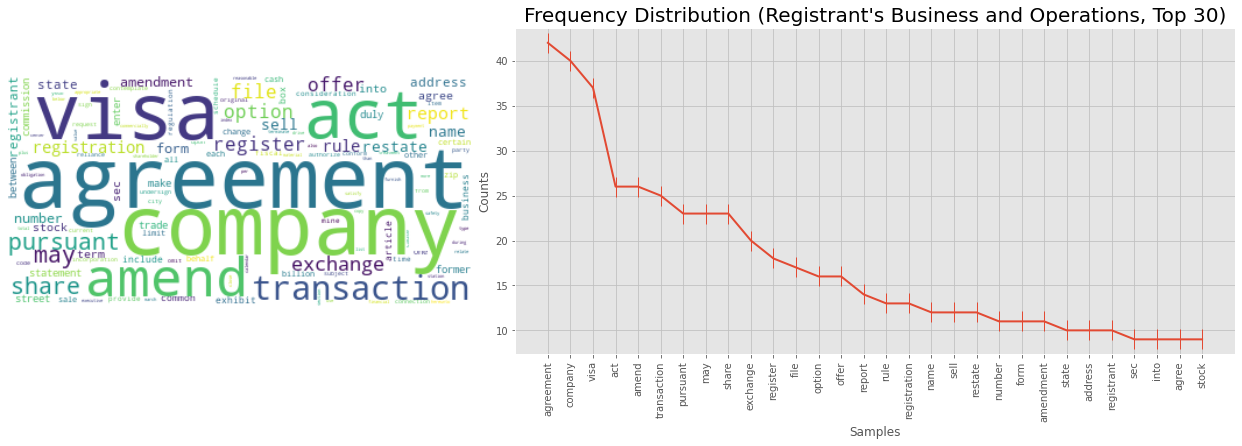

<Figure size 432x288 with 0 Axes>

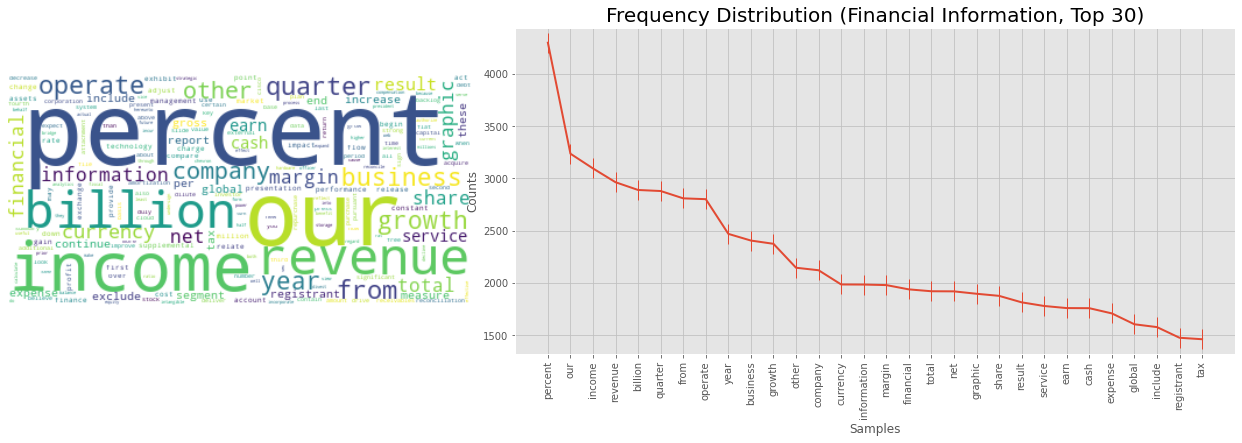

<Figure size 432x288 with 0 Axes>

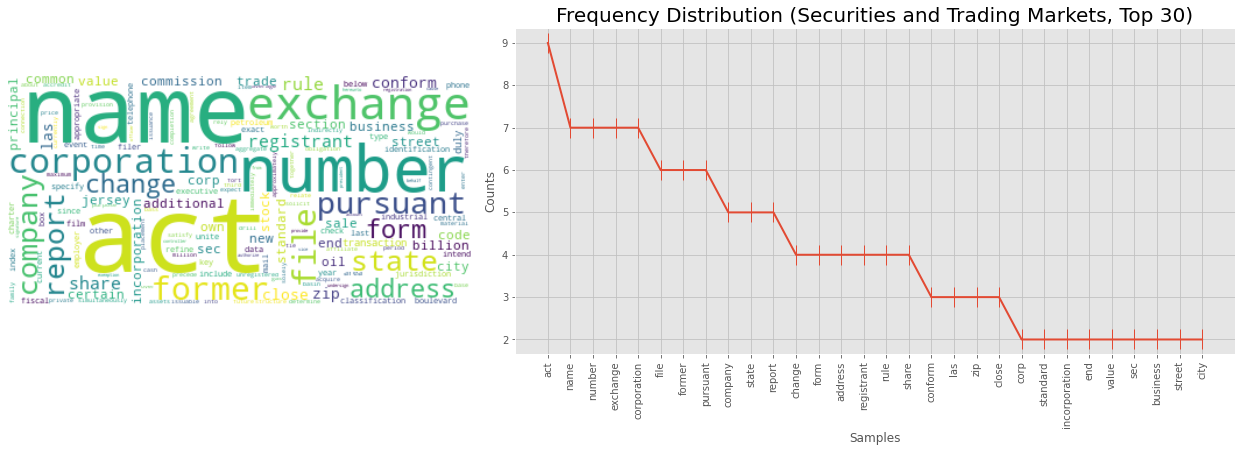

<Figure size 432x288 with 0 Axes>

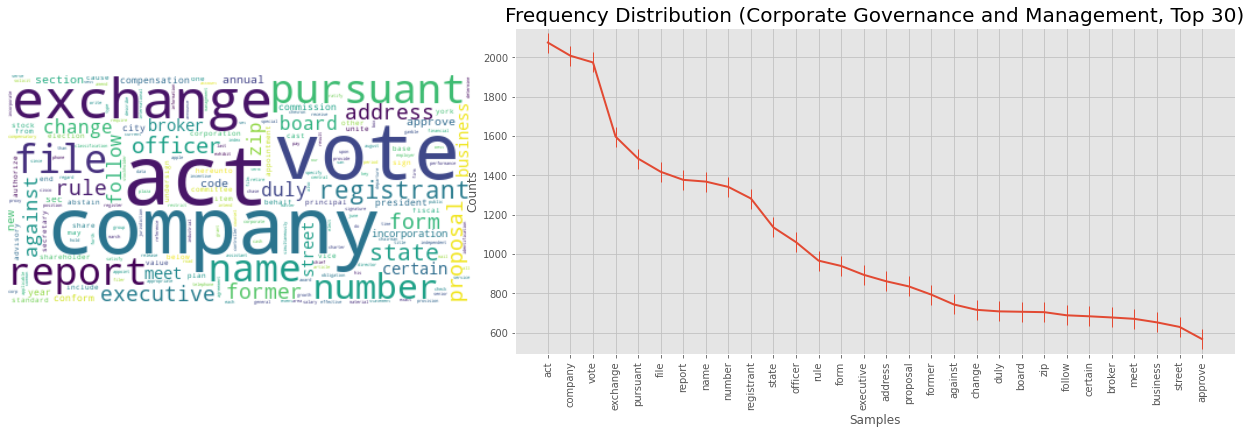

<Figure size 432x288 with 0 Axes>

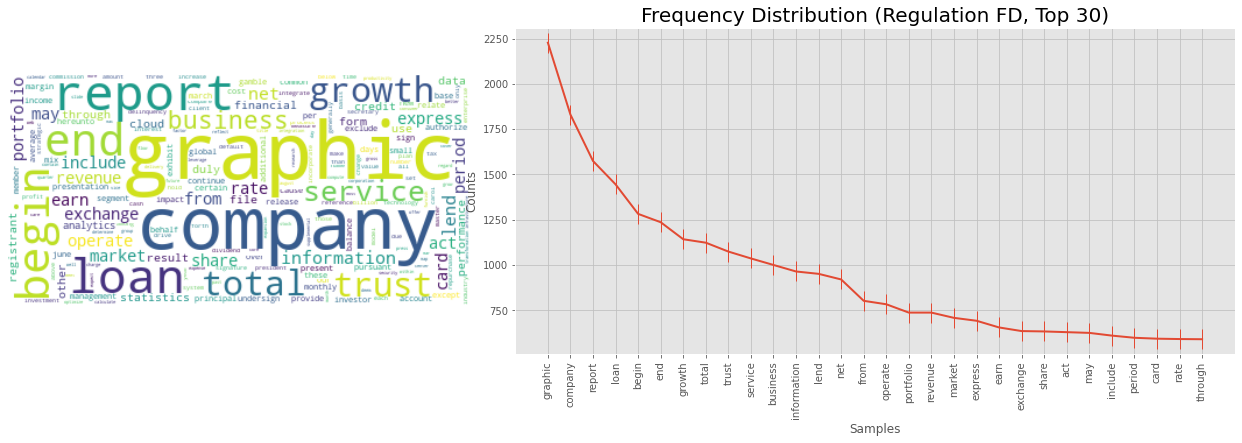

<Figure size 432x288 with 0 Axes>

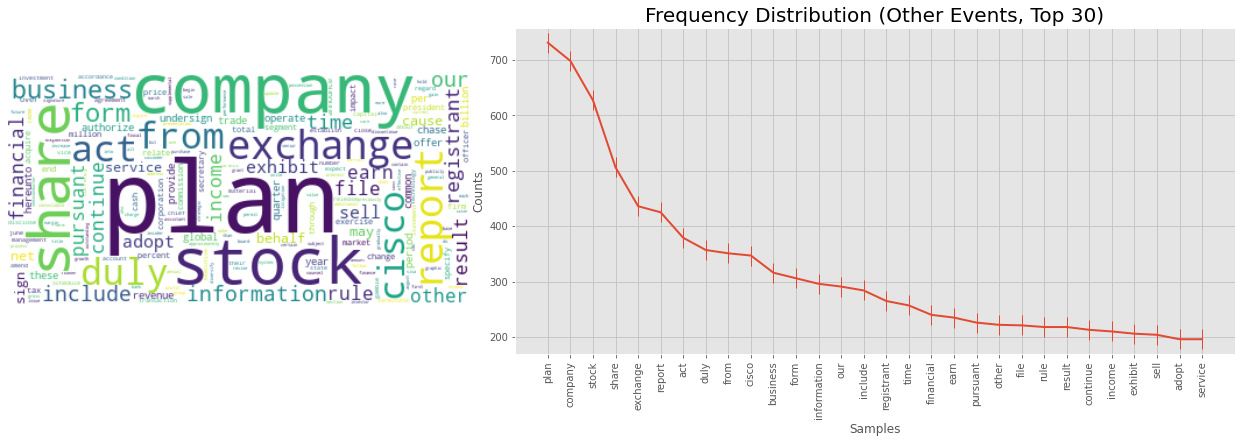

<Figure size 432x288 with 0 Axes>

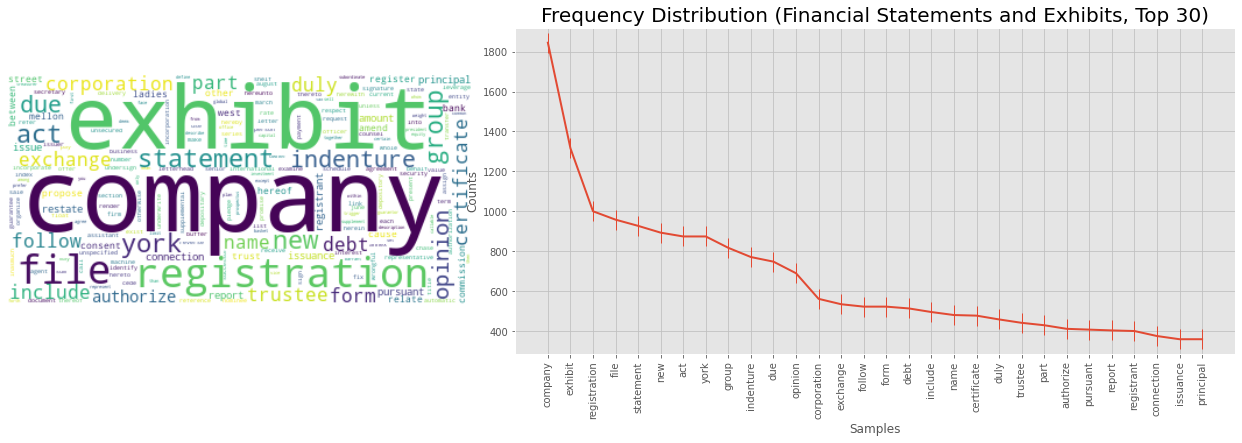

<Figure size 432x288 with 0 Axes>

In [49]:
for event in all_events:
    get_freqdist_wc(sub_df[sub_df.category == event]["joined_text_lemm"], event)

**Observation:**
There are distinct keywords for 'Registrant's Business and Operations', 'Financial Information', 'Corporate Governance and Management.'

- The 'Registrant's Business and Operations' category deals with agreement, merger with other stakeholders.
- 'Financial Information' reports the revenue, growth, income and the business numbers.
- 'Corporate Governance and Management' looks at things related to the roles, executive and the board.

Using text information can be a robust predictor for the different event/item types, which can facilitate the prediction of stock movement since it is expected that different events can have different impact on stock movement.

However, although we did preprocess and remove the stop words, we still end up with words that are very generic (e.g. company) that don't carry a specific meaning that may describe a topic

#### 3.3.4 Term Frequency-Inverse Document Frequency (tf-idf)

tf-idf is a numerical statistic intended to reflect how important a word is to a document or a corpus. The tf-idf of a term t in a document d is proportional to the number of times the word t appears in the document d but it also offset by the frequency of the term t in the collection of the documents of the corpus. This helps to adjust the fact that some words appear more frequently in general and don't especially carry a meaning.

tf-idf acts therefore as a weighting scheme to extract relevant words in a document.

In [50]:
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
# vectorizer = TfidfVectorizer(min_df=5, analyzer='word', stop_words='english')
vz = vectorizer.fit_transform(list(in_sample_df['processed_text_lemm'].map(lambda tokens: ' '.join(tokens))))

print(vz.shape)

(3236, 27631)


In [51]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

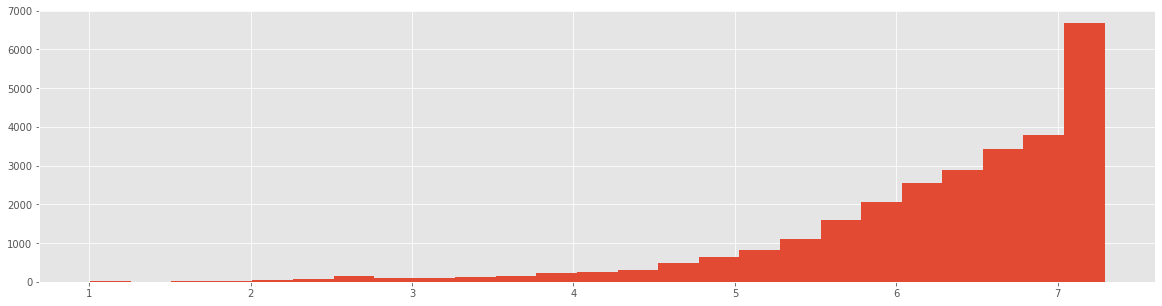

In [52]:
tfidf.tfidf.hist(bins=25, figsize=(20,5))
plt.show()

In [53]:
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

print(svd_tfidf.shape)

(3236, 50)


In [54]:
run = True
if run:
# run this (takes times)
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=1, perplexity=10, random_state=1234, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df["category"] = in_sample_df["category"]
    tsne_tfidf_df["num_events"] = in_sample_df["num_events"]
    tsne_tfidf_df["text"] = in_sample_df['processed_text_lemm']
    tsne_tfidf_df.to_csv('tsne_tfidf.csv', encoding='utf-8', index=False)
else:
# or import the dataset directly
    tsne_tfidf_df = pd.read_csv('tsne_tfidf.csv')

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3236 samples in 0.049s...
[t-SNE] Computed neighbors for 3236 samples in 0.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3236
[t-SNE] Computed conditional probabilities for sample 2000 / 3236
[t-SNE] Computed conditional probabilities for sample 3000 / 3236
[t-SNE] Computed conditional probabilities for sample 3236 / 3236
[t-SNE] Mean sigma: 0.048005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.855988
[t-SNE] KL divergence after 500 iterations: 0.661136
(3236, 2)


In [55]:
sub_df = tsne_tfidf_df[tsne_tfidf_df["num_events"] == 1]

In [56]:
sub_df["category"] = sub_df["category"].map(lambda x:x[0])

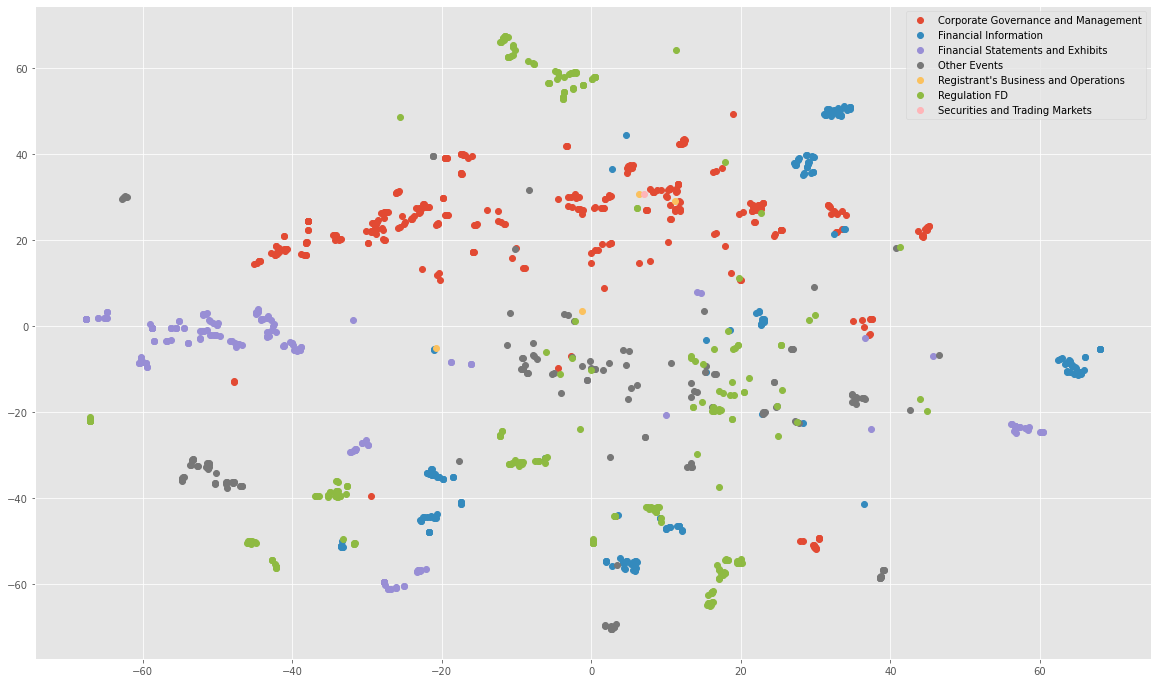

In [57]:
groups = sub_df.groupby('category')
fig, ax = plt.subplots(figsize=(20, 12))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()

### 3.3 N-Grams

In [58]:
token = ToktokTokenizer()
def generate_ngrams(text, n_gram=1):
    '''
    Generate n-grams
    Args:
      text: A string of words
      n_gram: An integer indicating the n_gram value. e.g. 1 for unigram, 2 for bigram etc
      stop_words: A list of stop words.
      remove_stop: Boolean; Set true to remove otherwise false to keep
    Returns:
      text: A string of n_grams
    '''
    
    tokens = token.tokenize(text)
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [59]:
N = 50
comment_type = "joined_text_stem"

In [60]:
# Unigrams
positive_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

for text in in_sample_df[in_sample_df["signal_5"] == "up"][comment_type]:
    for word in generate_ngrams(text):
        positive_unigrams[word] += 1
        
for text in in_sample_df[in_sample_df["signal_5"] == "down"][comment_type]:
    for word in generate_ngrams(text):
        negative_unigrams[word] += 1
        
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])

In [61]:
# Bigrams
positive_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

for text in in_sample_df[in_sample_df["signal_5"] == "up"][comment_type]:
    for word in generate_ngrams(text, n_gram=2):
        positive_bigrams[word] += 1
        
for text in in_sample_df[in_sample_df["signal_5"] == "down"][comment_type]:
    for word in generate_ngrams(text, n_gram=2):
        negative_bigrams[word] += 1
        
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])

In [62]:
# Trigrams
positive_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

for text in in_sample_df[in_sample_df["signal_5"] == "up"][comment_type]:
    for word in generate_ngrams(text, n_gram=3):
        positive_trigrams[word] += 1
        
for text in in_sample_df[in_sample_df["signal_5"] == "down"][comment_type]:
    for word in generate_ngrams(text, n_gram=3):
        negative_trigrams[word] += 1
        
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])

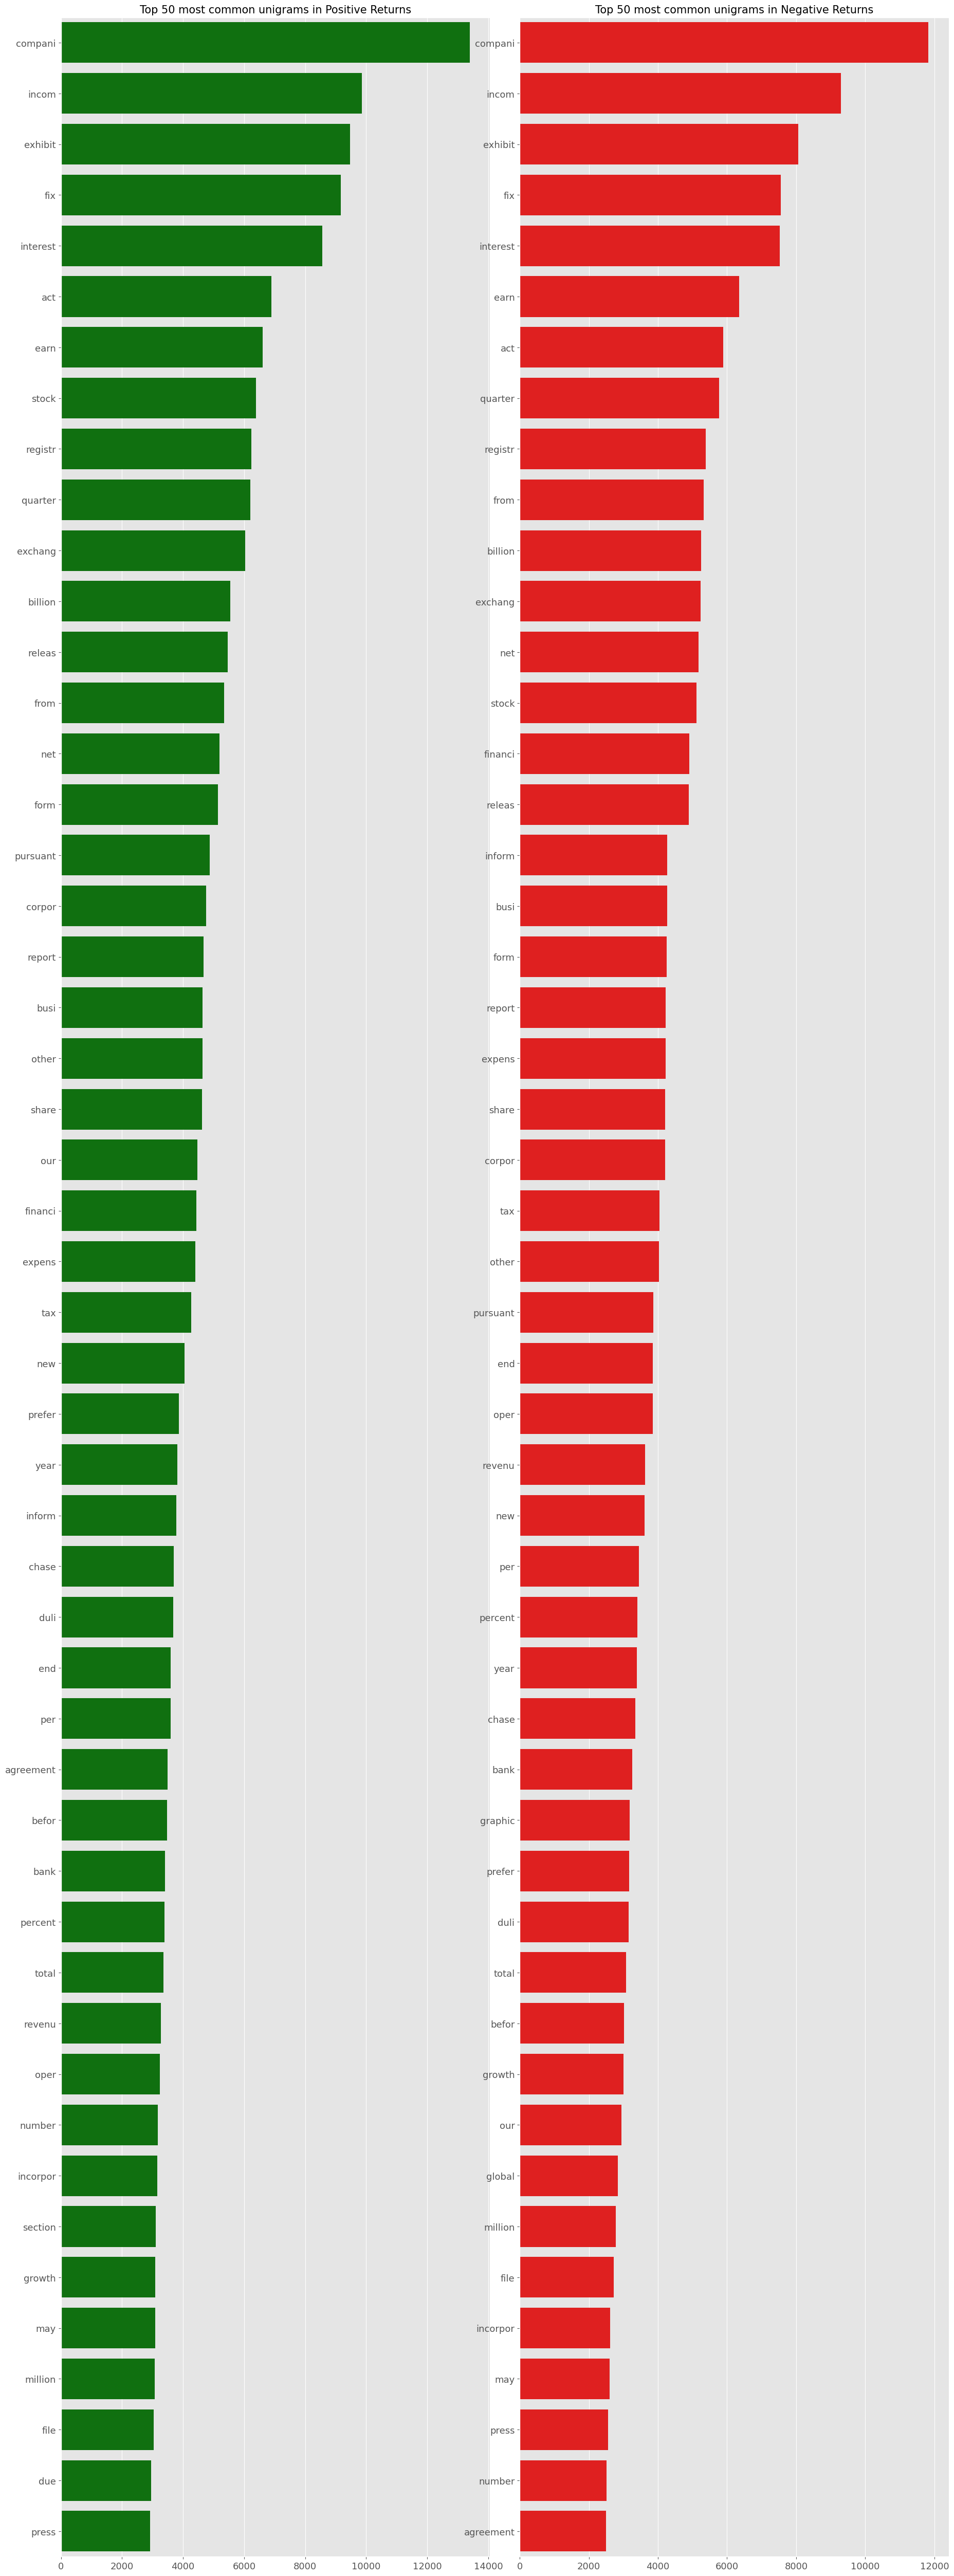

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_unigrams[0].values[:N], x=df_positive_unigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_negative_unigrams[0].values[:N], x=df_negative_unigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Positive Returns', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Returns', fontsize=15)

plt.show()

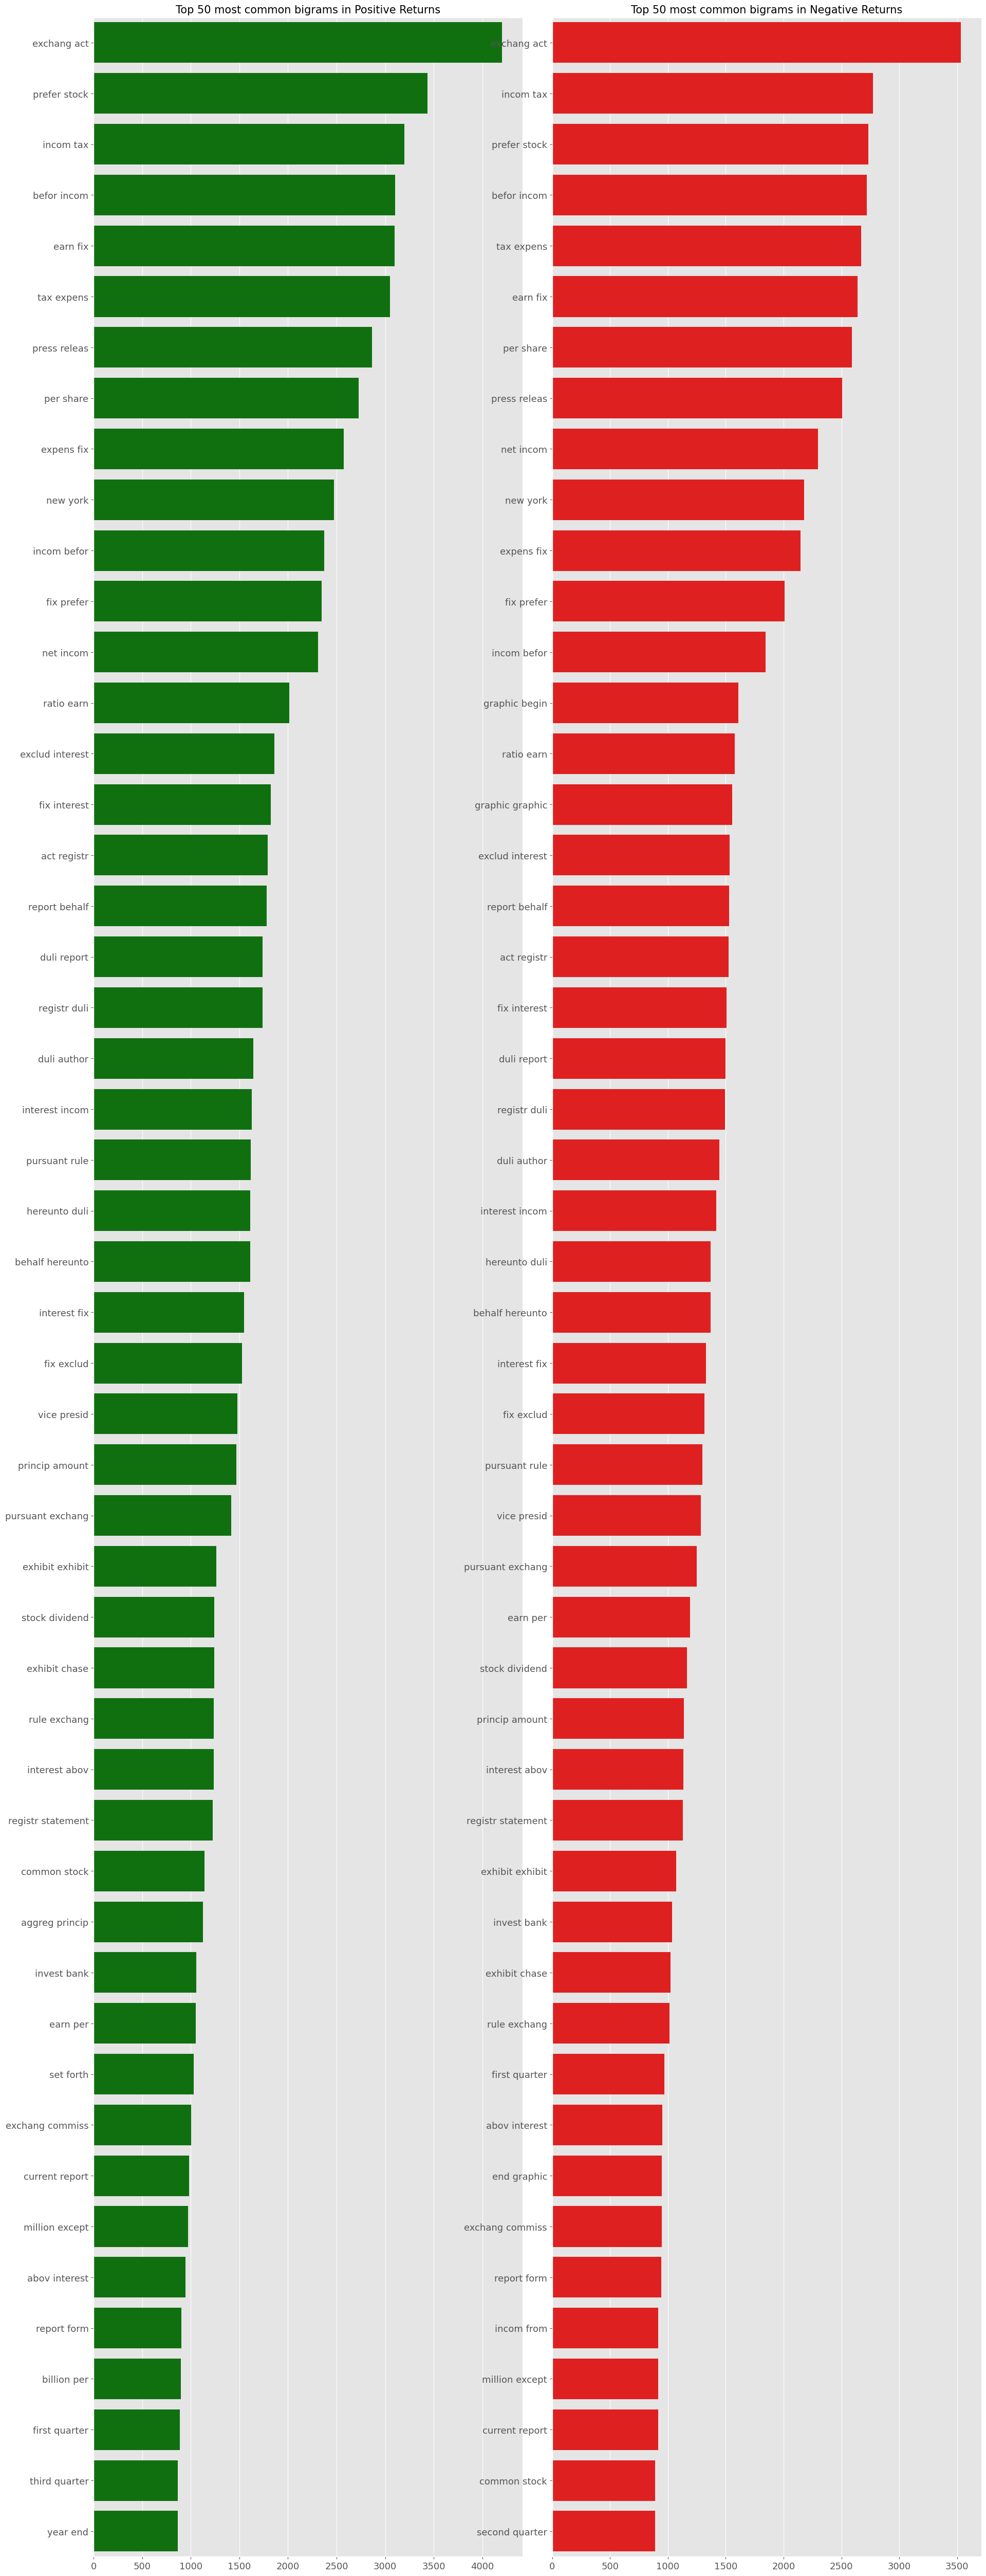

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_negative_bigrams[0].values[:N], x=df_negative_bigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Positive Returns', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Returns', fontsize=15)

plt.show()

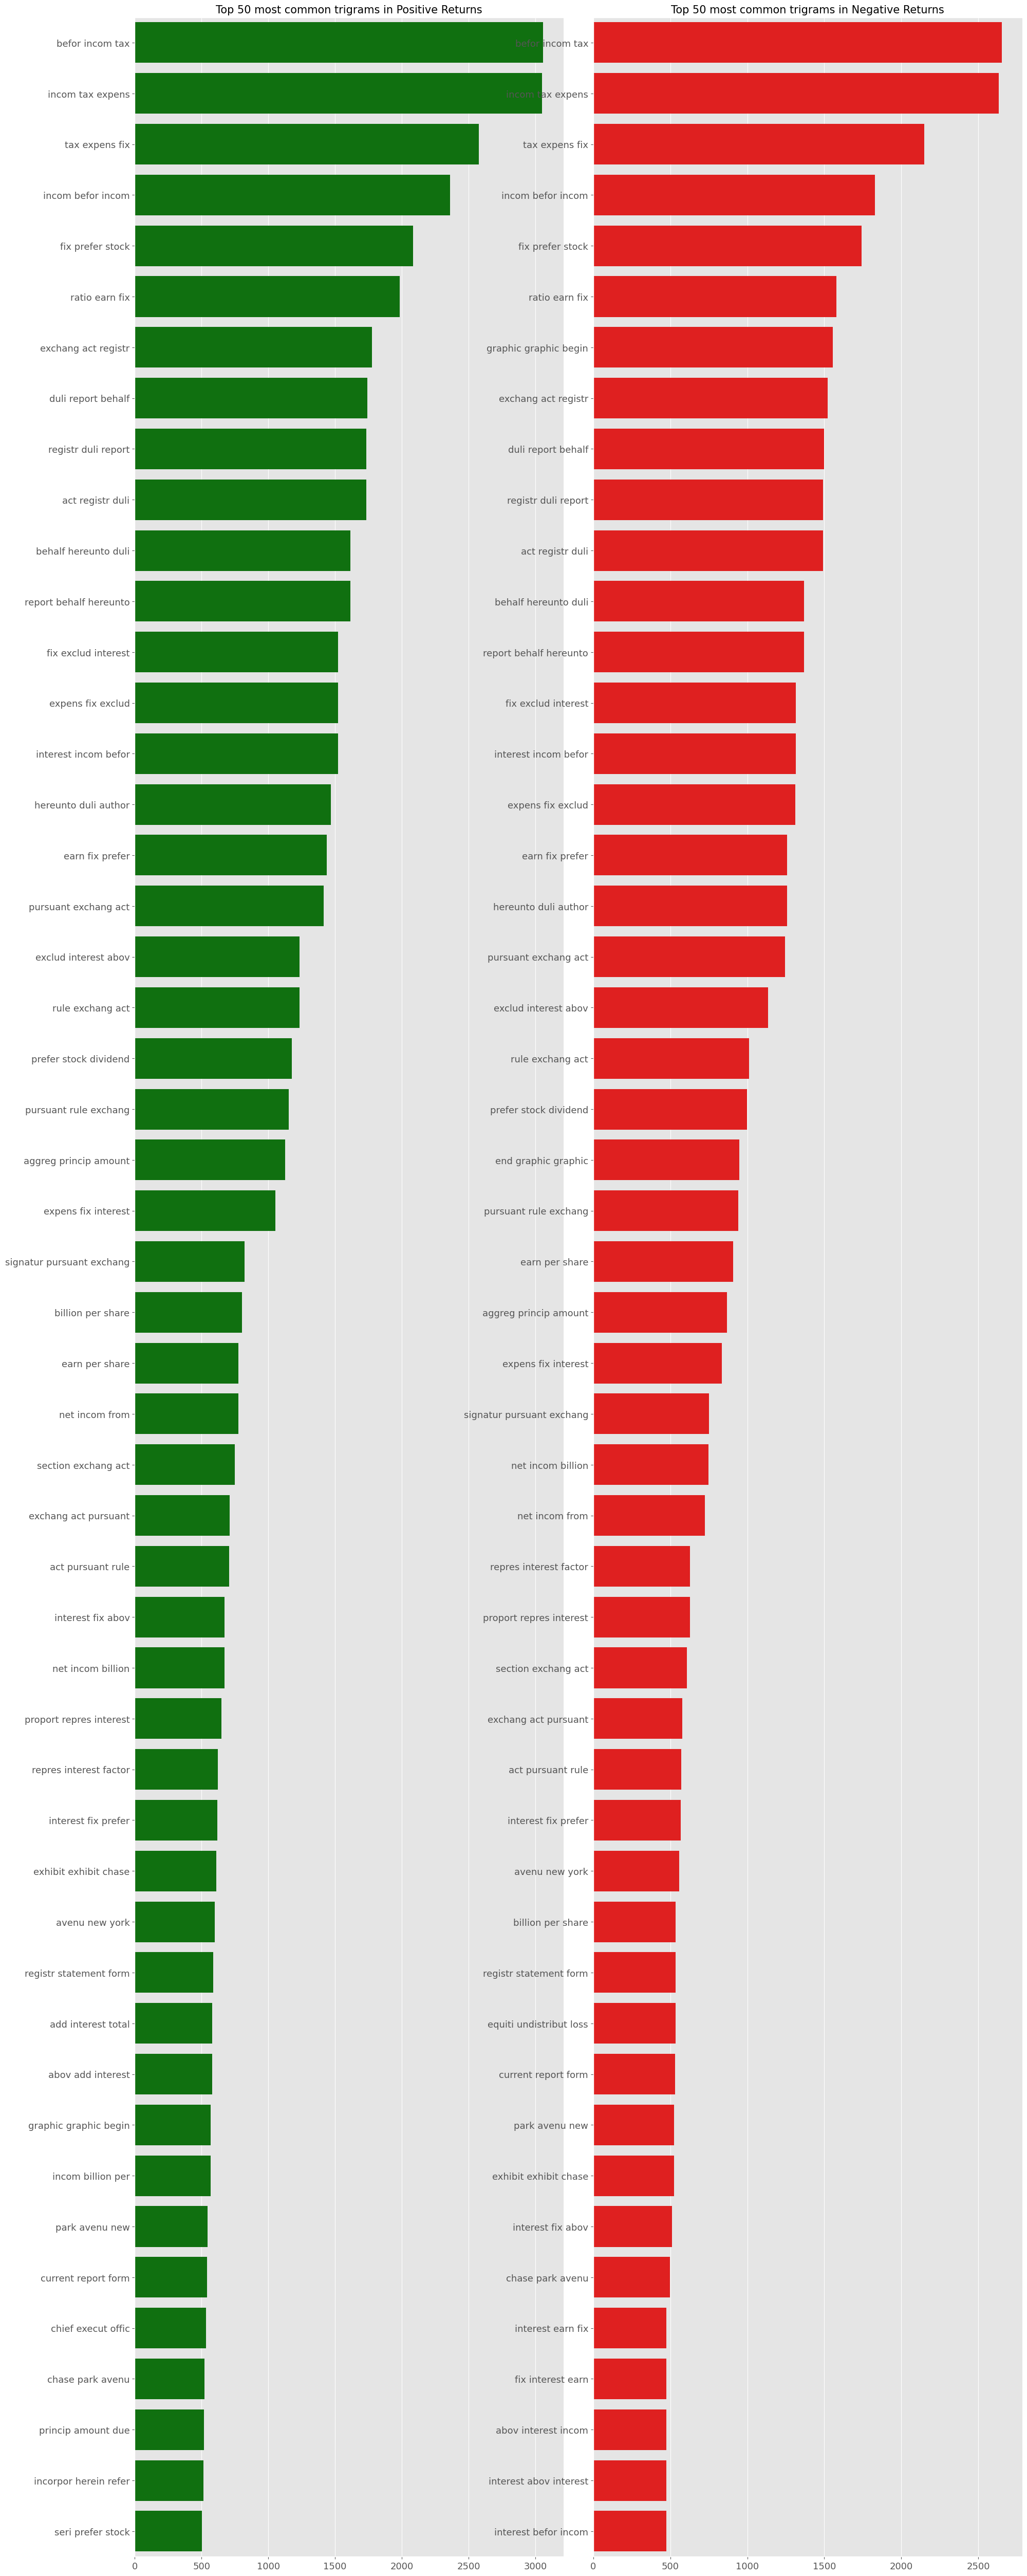

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_trigrams[0].values[:N], x=df_positive_trigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_negative_trigrams[0].values[:N], x=df_negative_trigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common trigrams in Positive Returns', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Negative Returns', fontsize=15)

plt.show()

## 4. Feature Engineering

### 4.1 TextBlob Sentiment Analysis

The sentiment function of textblob returns two properties, polarity, and subjectivity.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. 

In [66]:
def get_blob_sentiment(text):
    '''
    Function generate Text Blob scores
    Args:
      text: A string of words; 8-K Document
    Returns:
      A tuple containing the sentiment and subjectivity scores
    '''
    blob = TextBlob(text)
    scores = blob.sentiment
    
    return (scores[0], scores[1])

#### 4.1.1 Spread of TextBlob Sentiment and Blended Sentiment

The higher the polarity, the more positive or negative the sentiment, depending on the direction.
Subjectivity reflects public opinion, and hence the smaller the subjectivity, the more reliable/factual the score is.

**Feature Interaction:**
$$ blended_{tb} = \dfrac{polarity}{e^{subjectivity}} $$

In [67]:
in_sample_df["sentiment_tb"], in_sample_df["subjectivity_tb"] = zip(*in_sample_df["joined_text_lemm"].apply(get_blob_sentiment))




In [68]:
out_sample_df["sentiment_tb"], out_sample_df["subjectivity_tb"] = zip(*out_sample_df["joined_text_lemm"].apply(get_blob_sentiment))


In [69]:
in_sample_df = in_sample_df.sort_values("ticker")
out_sample_df = out_sample_df.sort_values("ticker")

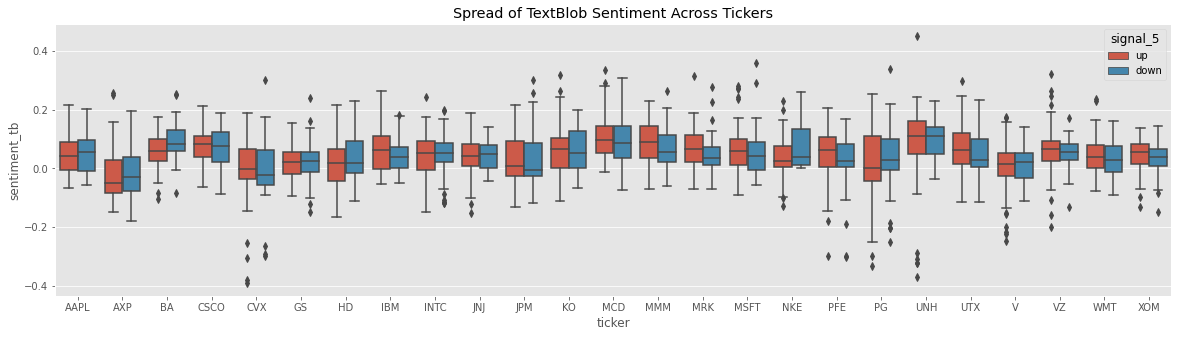

In [70]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="ticker", y="sentiment_tb", hue="signal_5", data=in_sample_df)
plt.title("Spread of TextBlob Sentiment Across Tickers")
plt.show()

In [71]:
in_sample_df["blended_tb"] = in_sample_df["sentiment_tb"] * np.exp(in_sample_df["subjectivity_tb"])

In [72]:
out_sample_df["blended_tb"] = out_sample_df["sentiment_tb"] * np.exp(out_sample_df["subjectivity_tb"])

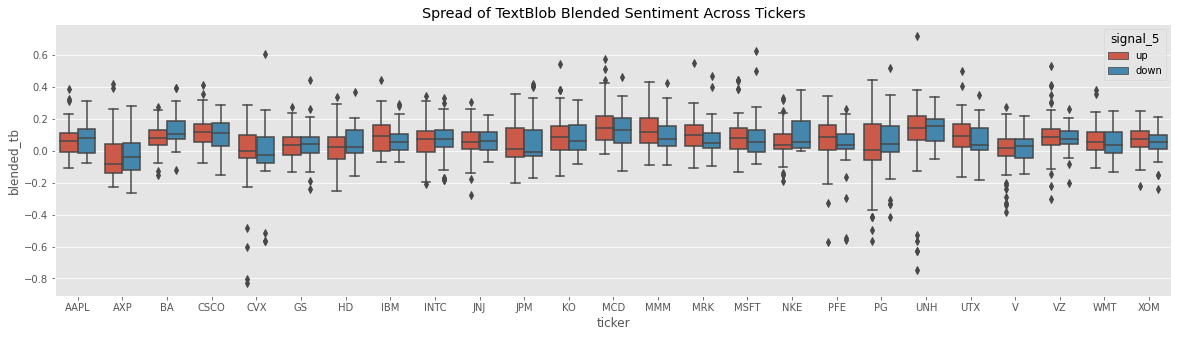

In [73]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="ticker", y="blended_tb", hue="signal_5", data=in_sample_df)
plt.title("Spread of TextBlob Blended Sentiment Across Tickers")
plt.show()

**Observation:** Generally, positive signals have a higher sentiment score than negative signals as shown by the higher median.

In [74]:
in_sample_df.columns == out_sample_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

#### 4.1.2 Correlation of TextBlob Sentiment Against Returns

**Idea:** To identify if there exist a linear relationship between TextBlob Sentiment and Returns

In [75]:
in_sample_df["year"] = in_sample_df.date.dt.year

In [76]:
out_sample_df["year"] = out_sample_df.date.dt.year

In [77]:
years = list(in_sample_df.year.unique())

In [78]:
horizon_window = [1, 3, 5, 10, 15, 20, 25, 30]

In [79]:
def correlation_rtns(horizon_window, years, final_df, sentiment_score, return_df = False):
    '''
    Function to generate a heatmap of the year by year correlation between sentiment_score and various forward returns
    Args:
      horizon_window: A list containing the different horizons of the returns
      years: A list containing all the unique years
      final_df: A Pandas `dataframe`
      sentiment_score: A string
    Returns:
      Heatmap of the year by year correlation
    '''
    years = [year for year in years if year not in [2018, 2019, 2020]]
    lag_cols = ["t+{}".format(i) for i in horizon_window]
    correl_df_tb = pd.DataFrame(index=years + ["overall"], columns = lag_cols)
    final_df = final_df[final_df.year.isin(years)]
    
    ## iterate through each year and each lag within that year
    for year in years:
        this_df = final_df[final_df.year == year]
        for lag in horizon_window:
            correl_df_tb["t+{}".format(lag)][year] = this_df["rtns_{}".format(lag)].corr(this_df[sentiment_score])
    
    for lag in horizon_window:
        correl_df_tb["t+{}".format(lag)]["overall"] = final_df["rtns_{}".format(lag)].corr(final_df[sentiment_score])
    
    correl_df_tb = correl_df_tb[correl_df_tb.columns].astype(float) 
    
    if return_df:
        return(correl_df_tb)
    
    # Prepare the figure
    fig = plt.figure(figsize=(20,10))
    title = fig.suptitle('Correlation Year by Year - Text Blob {} against Forward Returns'.format(sentiment_score), fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.9, wspace=0.3)
    
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_ticks_position('top')
    sns.heatmap(correl_df_tb.transpose(), ax=ax, norm = DivergingNorm(0),vmin=-1, vmax=1, square=True, annot=True, cmap=GnRd)
    
    
    

##### Blended Sentiments

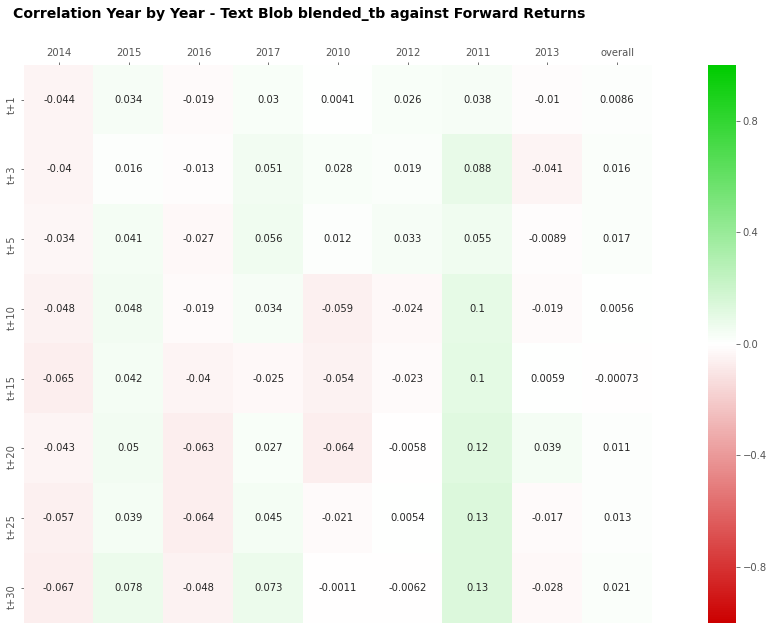

In [80]:
correlation_rtns(horizon_window, years, in_sample_df, "blended_tb")

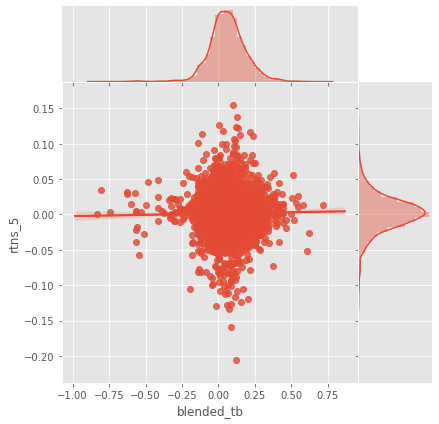

In [81]:
jp = sns.jointplot(x='blended_tb', 
                   y='rtns_5', 
                   data=in_sample_df,
                   kind='reg', # <-- Add regression and kernel density fits
                   space=0, height=6, ratio=4)

**Observation:** There is no strong overall correlation. However, if we were to obseve year by year, there are some years where the correlation between sentiment and returns is relatively stronger. Comparing all forward returns, we will use **t+5 forward returns** as the target variable since it has the "highest" correlation. This accounts for the delayed effect of events on stock prices.

In [82]:
tickers = list(in_sample_df.ticker.unique())

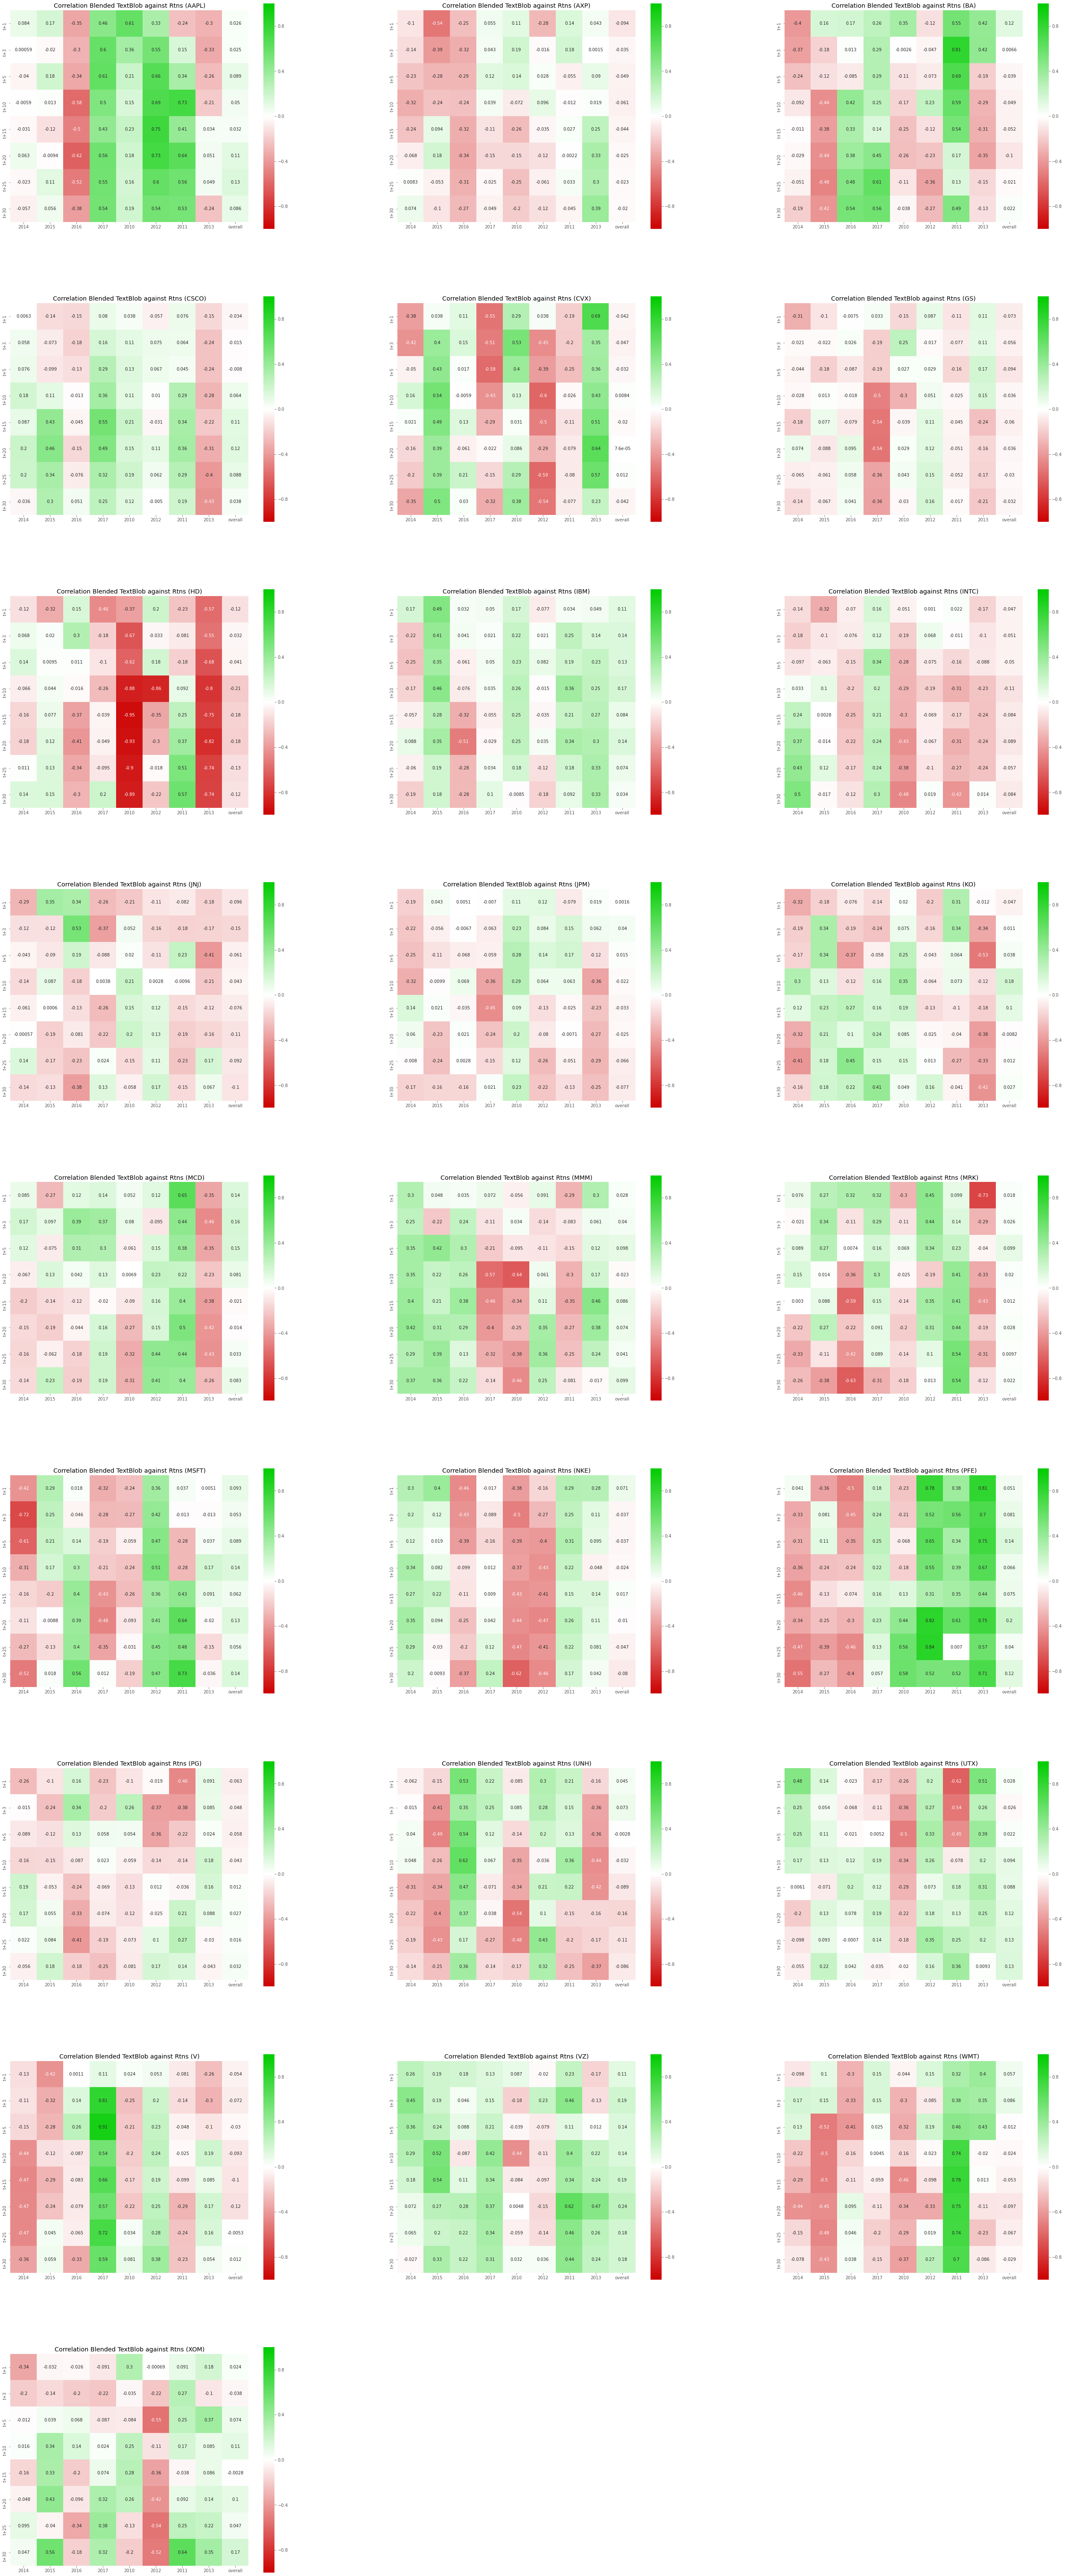

In [83]:
fig = plt.figure(constrained_layout=False, figsize=(45,300))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(tickers)):
    axes = fig.add_subplot(spec[i])
    df = correlation_rtns(horizon_window, years, in_sample_df[in_sample_df.ticker == tickers[i]], "blended_tb", return_df = True)
    sns.heatmap(df.transpose(), norm = DivergingNorm(0),vmin=-1, vmax=1, square=True, annot=True, cmap=GnRd)
    fig.add_subplot(axes)
    axes.title.set_text('Correlation Blended TextBlob against Rtns ({})'.format(tickers[i]))

fig.show()

**Observation:** Sentiment Scores react differntly to returns at across different years and different tickers. Hence, having tickers as a feature can improve prediction.

#### 4.1.3 Analyse Distribution of TextBlob Sentiments by Signal Direction (Across all Tickers)

**Idea:** To see whether TextBlob Sentiments can distinctively separate the positive and negatives signals.

##### Distribution of Blended Sentiments

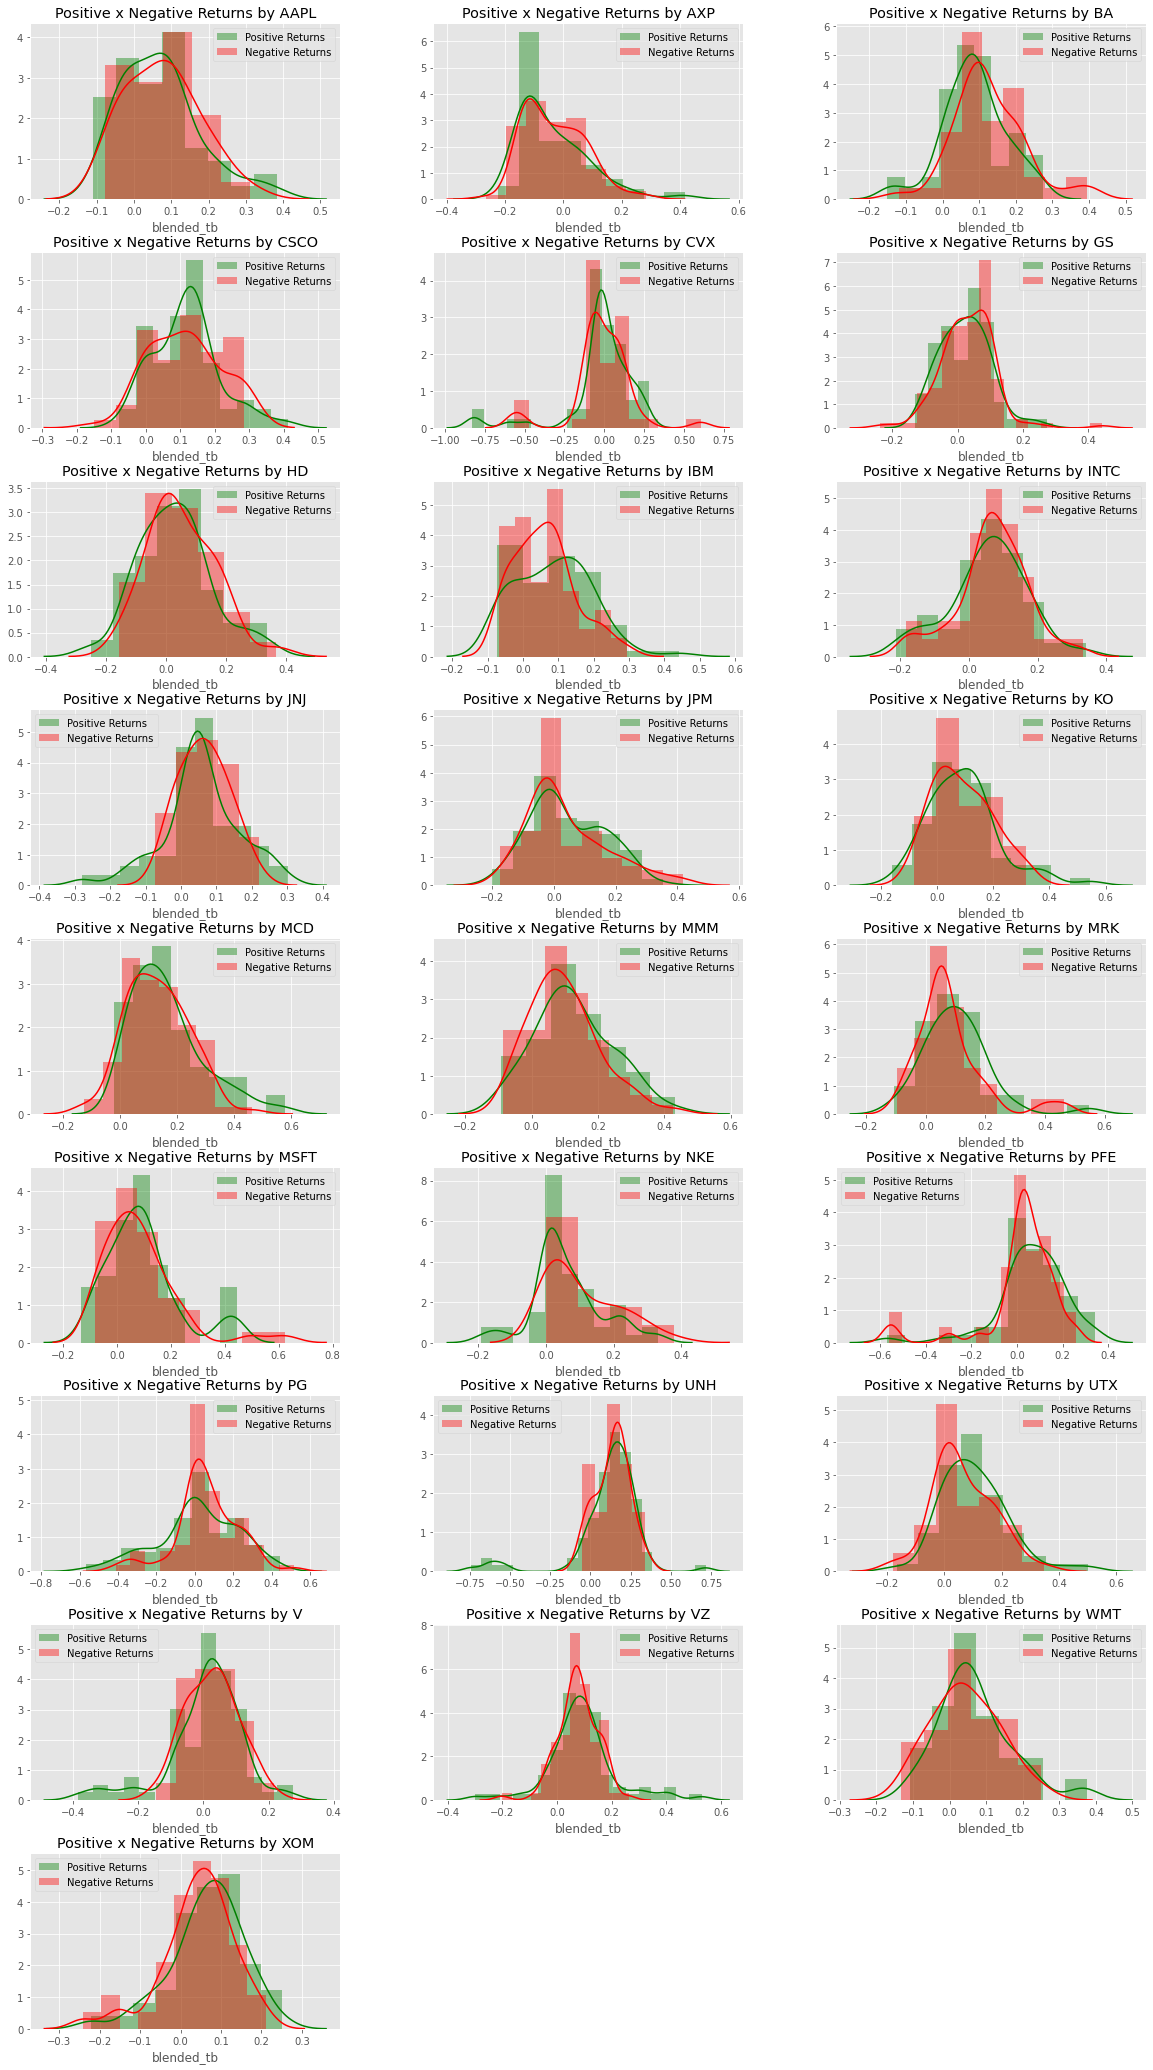

In [84]:
fig = plt.figure(constrained_layout=False, figsize=(20,100))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(tickers)):
    axes = fig.add_subplot(spec[i])
    ticker = sorted(tickers)[i]
    sns.distplot(in_sample_df[(in_sample_df['signal_5'] == "up") & (in_sample_df["ticker"] == ticker)]["blended_tb"], 
             color='g', label="Positive Returns")
    sns.distplot(in_sample_df[(in_sample_df['signal_5'] == "down") & (in_sample_df["ticker"] == ticker)]["blended_tb"], 
                 color='r', label="Negative Returns")
    fig.add_subplot(axes)
    axes.title.set_text('Positive x Negative Returns by {}'.format(ticker))
    plt.legend(prop={'size': 10})

fig.show()

**Observation:** There is no clear separation of the positive and negative signals in the TextBlob Sentiment's Distribution. This reinforces with earlier observation that the overall correlation between the sentiment score and returns is generally weak.

In [85]:
in_sample_df.columns == out_sample_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### 4.2 Loughran McDonald Sentiment Word Lists

We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:

- Negative
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 8-Ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

#### 4.2.1 Construct Sentiment Ratios

In [86]:
fin_sentiments = pd.ExcelFile("LoughranMcDonald_SentimentWordLists_2018.xlsx")

In [87]:
positive_sentiments = pd.read_excel(fin_sentiments, "Positive", header=None)
positive_sentiments = list(set([SnowballStemmer("english").stem(w) for w in positive_sentiments[0].str.lower()]))


In [88]:
negative_sentiments = pd.read_excel(fin_sentiments, "Negative", header=None)
negative_sentiments = list(set([SnowballStemmer("english").stem(w) for w in negative_sentiments[0].str.lower()]))


In [89]:
uncertain_sentiments = pd.read_excel(fin_sentiments, "Uncertainty", header=None)
uncertain_sentiments = list(set([SnowballStemmer("english").stem(w) for w in uncertain_sentiments[0].str.lower()]))


In [90]:
litigious_sentiments = pd.read_excel(fin_sentiments, "Litigious", header=None)
litigious_sentiments = list(set([SnowballStemmer("english").stem(w) for w in litigious_sentiments[0].str.lower()]))


In [91]:
strong_modal = pd.read_excel(fin_sentiments, "StrongModal", header=None)
strong_modal = list(set([SnowballStemmer("english").stem(w) for w in strong_modal[0].str.lower()]))


In [92]:
weak_modal = pd.read_excel(fin_sentiments, "WeakModal", header=None)
weak_modal = list(set([SnowballStemmer("english").stem(w) for w in weak_modal[0].str.lower()]))


In [93]:
constraints = pd.read_excel(fin_sentiments, "Constraining", header=None)
constraints = list(set([SnowballStemmer("english").stem(w) for w in constraints[0].str.lower()]))


In [94]:
def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Args
      sentiment_words: Pandas Series
          Words that signify a certain sentiment
      docs : list of str
          List of documents used to generate bag of words

    Returns
      bag_of_words : 2-d Numpy Ndarray of int
          Bag of words sentiment for each document
          The first dimension is the document.
          The second dimension is the word.
    """
    
    cnt_vec = CountVectorizer(vocabulary=sentiment_words)
    bag_of_words = cnt_vec.fit_transform(docs).toarray()
    
    return bag_of_words

In [95]:
sentiments = {
    "positive": positive_sentiments,
    "negative": negative_sentiments, 
    "uncertain": uncertain_sentiments,
    "litigious": litigious_sentiments,
    "strong_modal": strong_modal,
    "weak_modal": weak_modal,
    "constraints": constraints
}

In [96]:
in_sample_df["doc_length_stem"] = in_sample_df.processed_text_stem.map(len)
out_sample_df["doc_length_stem"] = out_sample_df.processed_text_stem.map(len)

In [97]:
doc_sentiments_all = {sentiment: get_bag_of_words(sentiments[sentiment], in_sample_df.joined_text_stem) for sentiment in sentiments}


In [98]:
in_sample_df["positive_ratio"] = pd.DataFrame(doc_sentiments_all["positive"]).sum(axis=1)/in_sample_df.doc_length_stem
in_sample_df["negative_ratio"] = pd.DataFrame(doc_sentiments_all["negative"]).sum(axis=1)/in_sample_df.doc_length_stem
in_sample_df["uncertain_ratio"] = pd.DataFrame(doc_sentiments_all["uncertain"]).sum(axis=1)/in_sample_df.doc_length_stem
in_sample_df["litigious_ratio"] = pd.DataFrame(doc_sentiments_all["litigious"]).sum(axis=1)/in_sample_df.doc_length_stem
in_sample_df["strong_modal_ratio"] = pd.DataFrame(doc_sentiments_all["strong_modal"]).sum(axis=1)/in_sample_df.doc_length_stem
in_sample_df["weak_modal_ratio"] = pd.DataFrame(doc_sentiments_all["weak_modal"]).sum(axis=1)/in_sample_df.doc_length_stem
in_sample_df["constraints_ratio"] = pd.DataFrame(doc_sentiments_all["constraints"]).sum(axis=1)/in_sample_df.doc_length_stem


In [99]:
doc_sentiments_all_oos = {sentiment: get_bag_of_words(sentiments[sentiment], out_sample_df.joined_text_stem) for sentiment in sentiments}


In [100]:
out_sample_df["positive_ratio"] = pd.DataFrame(doc_sentiments_all_oos["positive"]).sum(axis=1)/out_sample_df.doc_length_stem
out_sample_df["negative_ratio"] = pd.DataFrame(doc_sentiments_all_oos["negative"]).sum(axis=1)/out_sample_df.doc_length_stem
out_sample_df["uncertain_ratio"] = pd.DataFrame(doc_sentiments_all_oos["uncertain"]).sum(axis=1)/out_sample_df.doc_length_stem
out_sample_df["litigious_ratio"] = pd.DataFrame(doc_sentiments_all_oos["litigious"]).sum(axis=1)/out_sample_df.doc_length_stem
out_sample_df["strong_modal_ratio"] = pd.DataFrame(doc_sentiments_all_oos["strong_modal"]).sum(axis=1)/out_sample_df.doc_length_stem
out_sample_df["weak_modal_ratio"] = pd.DataFrame(doc_sentiments_all_oos["weak_modal"]).sum(axis=1)/out_sample_df.doc_length_stem
out_sample_df["constraints_ratio"] = pd.DataFrame(doc_sentiments_all_oos["constraints"]).sum(axis=1)/out_sample_df.doc_length_stem


In [101]:
in_sample_df.columns == out_sample_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

#### 4.2.2 Correlation of Sentiment Ratios against Different Forward Returns

In [102]:
sentiment_scores = ["positive_ratio", "negative_ratio", "uncertain_ratio", "litigious_ratio", "strong_modal_ratio", "weak_modal_ratio"]
fwd_rtns = ["rtns_{}".format(i) for i in horizon_window]


In [103]:
def correlation_rtns_mcdonald(horizon_window, mcdonald_df, sentiment_scores, return_df=False):
    '''
    Function to generate heatmap of the correlation between each sentiment and the forward returns
    Args:
      horizon_window: A list containing the different horizons of returns
      mcdonald_df: A Pandas `dataframe`
      sentiment_scores: A list containing the Loughran Mcdonald Sentiment Names
      return_df: A boolean indicating whether the resultant dataframe of the heatmap will be returned
    Returns:
      A heatmap of the correlation between each sentiment and the forward returns
    '''
    correl_df_1 = pd.DataFrame(index = ["t+{}".format(i) for i in horizon_window], 
                               columns = sentiment_scores)
    
    ## iterate through each year and each factor within that year
    for factor in correl_df_1.columns:
        for lag in horizon_window:
            correl_df_1[factor]["t+{}".format(lag)] = mcdonald_df["rtns_{}".format(lag)].corr(mcdonald_df[factor])
    
    correl_df_1 = correl_df_1[correl_df_1.columns].astype(float)
    
    if return_df:
        return correl_df_1
    
    # Prepare the figure
    fig = plt.figure(figsize=(20,10))
    title = fig.suptitle('Correlation of Sentiments against Lagged Returns', fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.9, wspace=0.3)
    
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_ticks_position('top')
    sns.heatmap(correl_df_1.transpose(), norm = DivergingNorm(0),vmin=-1, vmax=1,square=True,annot=True,cmap=GnRd)


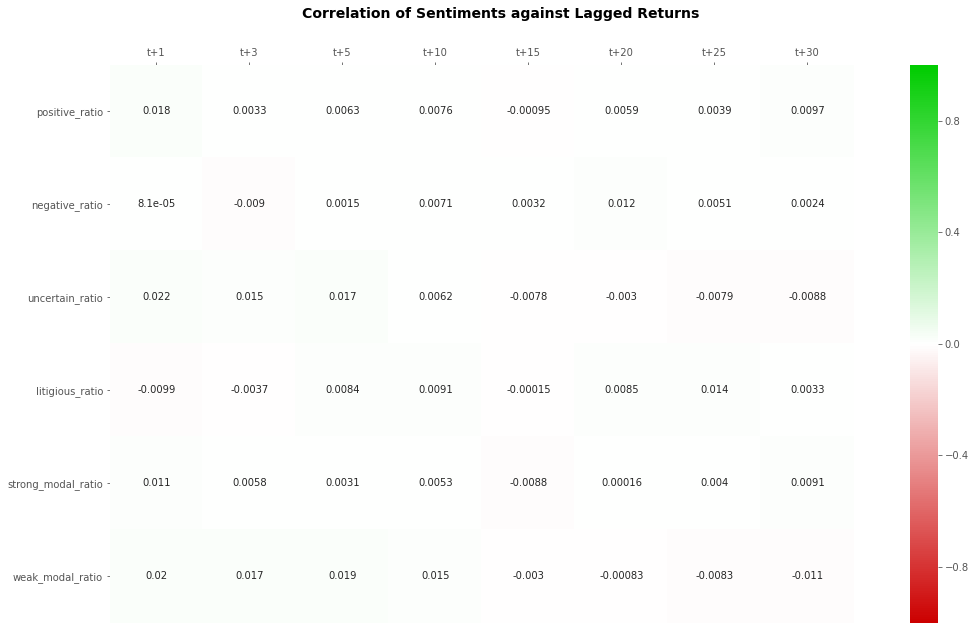

In [104]:
correlation_rtns_mcdonald(horizon_window, in_sample_df, sentiment_scores)

**Observation:** Correlation with **t+5 returns** make the most intuitive sense across the different sentiment ratios.

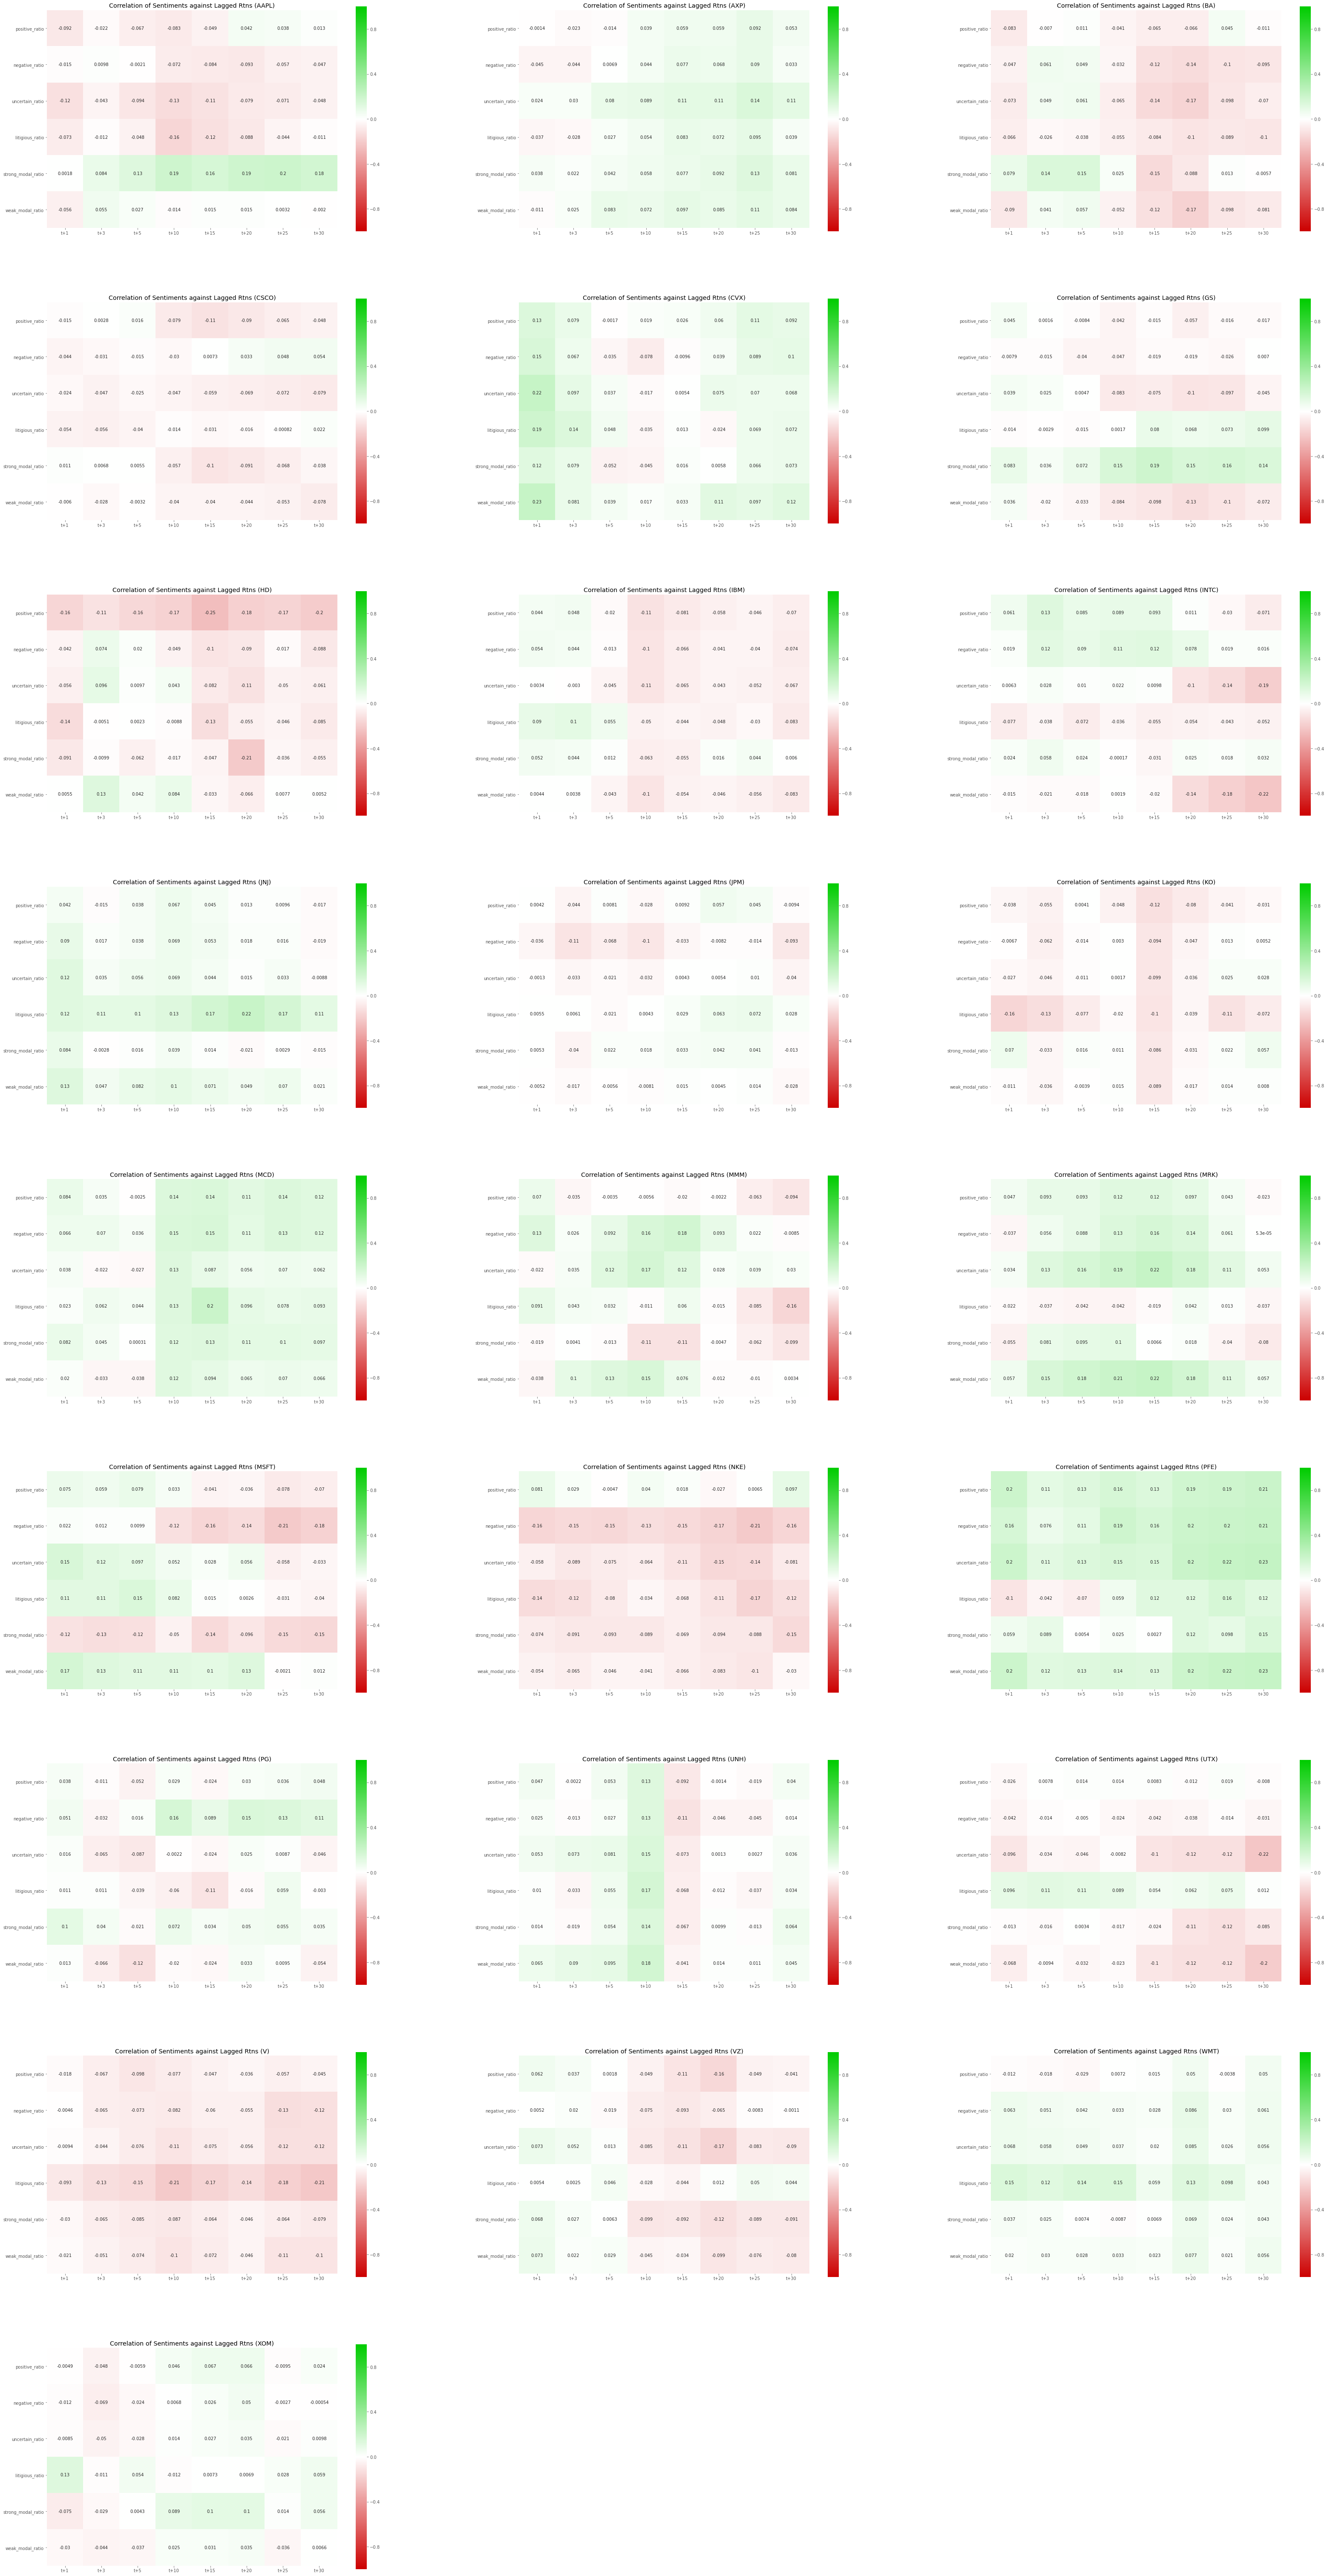

In [105]:
fig = plt.figure(constrained_layout=False, figsize=(55,300))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(tickers)):
    axes = fig.add_subplot(spec[i])
    df = correlation_rtns_mcdonald(horizon_window, in_sample_df[in_sample_df.ticker == tickers[i]], sentiment_scores, return_df = True)
    sns.heatmap(df.transpose(), norm = DivergingNorm(0),vmin=-1, vmax=1, square=True, annot=True, cmap=GnRd)
    fig.add_subplot(axes)
    axes.title.set_text('Correlation of Sentiments against Lagged Rtns ({})'.format(tickers[i]))

fig.show()

**Observation:** Correlation is stronger when using individual ticker data.

In [106]:
def correlation_rtns_mcdonald_yoy(years, mcdonald_df, sentiment_scores, return_df=False):
    '''
    Function to generate the heatmap of the year by year correlation between the Loughran Mcdonald Sentiments and the t+5 returns
    Args:
      years: A list containing all the unique years
      mcdonald_df: A Pandas `dataframe`
      sentiment_scores: A list containing the names of the Loughran Mcdonald Sentiments
      return_df: A boolean indicating whether the resultant dataframe of the heatmap will be returned
    Returns:
     A heatmap of the year by year correlation between sentiment and t+5 returns
    '''
    correl_df_2 = pd.DataFrame(index = years, 
                               columns = sentiment_scores)

    ## iterate through each year and each factor within that year
    for year in years:
        this_df = mcdonald_df[mcdonald_df.year == year]
        for factor in correl_df_2.columns:
            correl_df_2[factor][year] = this_df["rtns_5"].corr(this_df[factor])
    
    correl_df_2 = correl_df_2[correl_df_2.columns].astype(float)
    
    if return_df:
        return correl_df_2
    
    # Prepare the figure
    fig = plt.figure(figsize=(20,10))
    title = fig.suptitle('Year by Year Correlation on t+5 returns', fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.9, wspace=0.3)
    
    ax = fig.add_subplot(1,1,1)
    ax.xaxis.set_ticks_position('top')
    sns.heatmap(correl_df_2.transpose(), norm = DivergingNorm(0),vmin=-1, vmax=1,square=True,annot=True,cmap=GnRd)


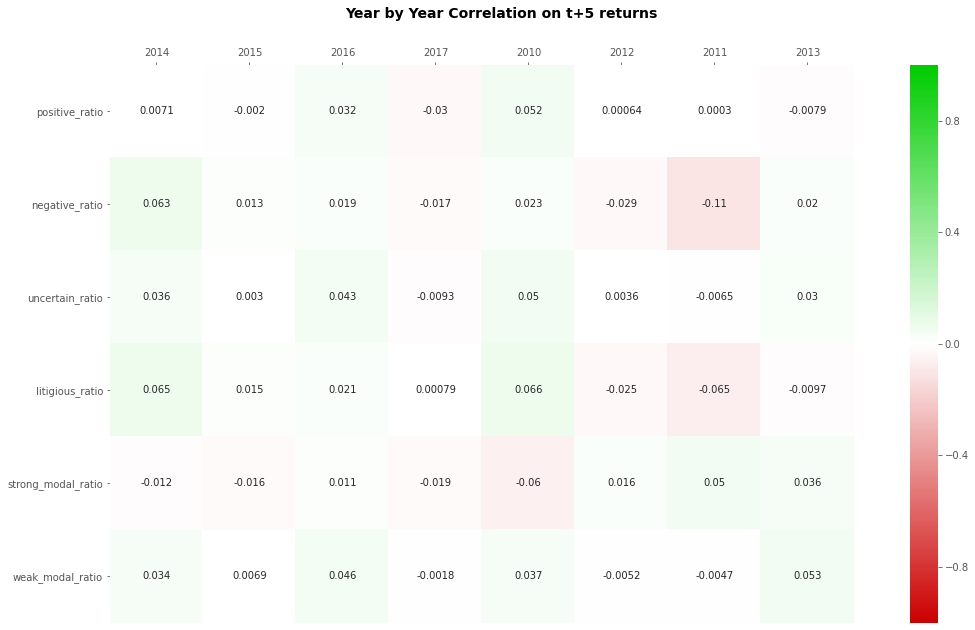

In [107]:
correlation_rtns_mcdonald_yoy(years, in_sample_df, sentiment_scores)

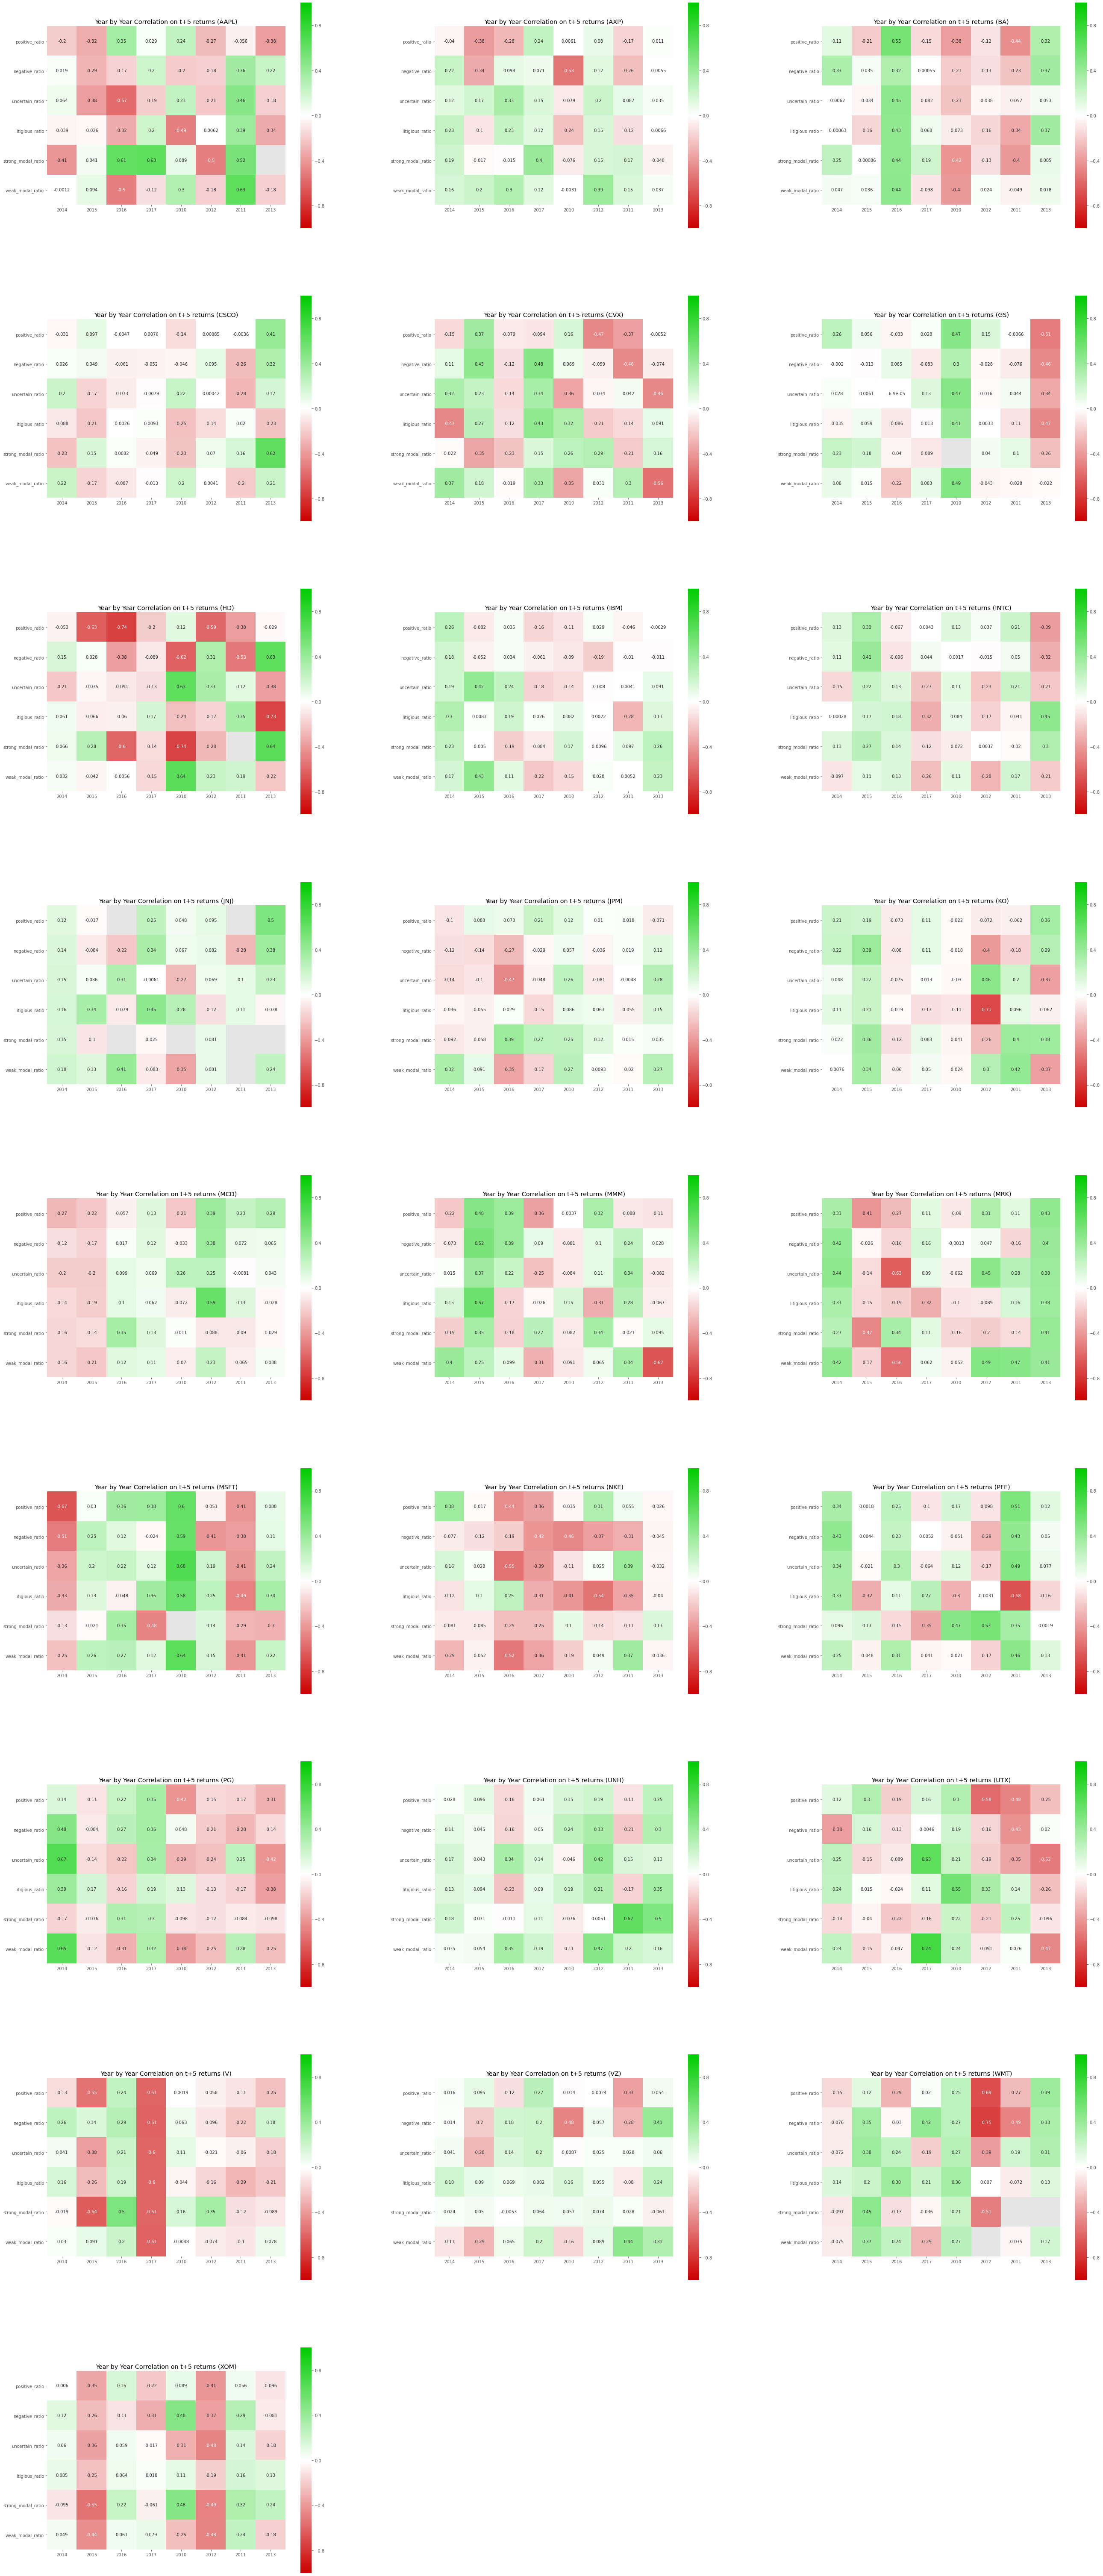

In [108]:
fig = plt.figure(constrained_layout=False, figsize=(45,300))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(tickers)):
    axes = fig.add_subplot(spec[i])
    df = correlation_rtns_mcdonald_yoy(years, in_sample_df[in_sample_df.ticker == tickers[i]], sentiment_scores, return_df = True)
    sns.heatmap(df.transpose(), norm = DivergingNorm(0),vmin=-1, vmax=1, square=True, annot=True, cmap=GnRd)
    fig.add_subplot(axes)
    axes.title.set_text('Year by Year Correlation on t+5 returns ({})'.format(tickers[i]))

fig.show()

### 4.3 Correlation Heatmap and Scatter Matrix of Numerical Features + Returns

In [109]:
num_cols = ["rtns_5", "sentiment_tb", "subjectivity_tb", "blended_tb"] + sentiment_scores

In [110]:
import scipy.stats as spstats
test = in_sample_df[num_cols]

for col in sentiment_scores:
    test[col] = spstats.boxcox(test[col]+1, lmbda=0)
    


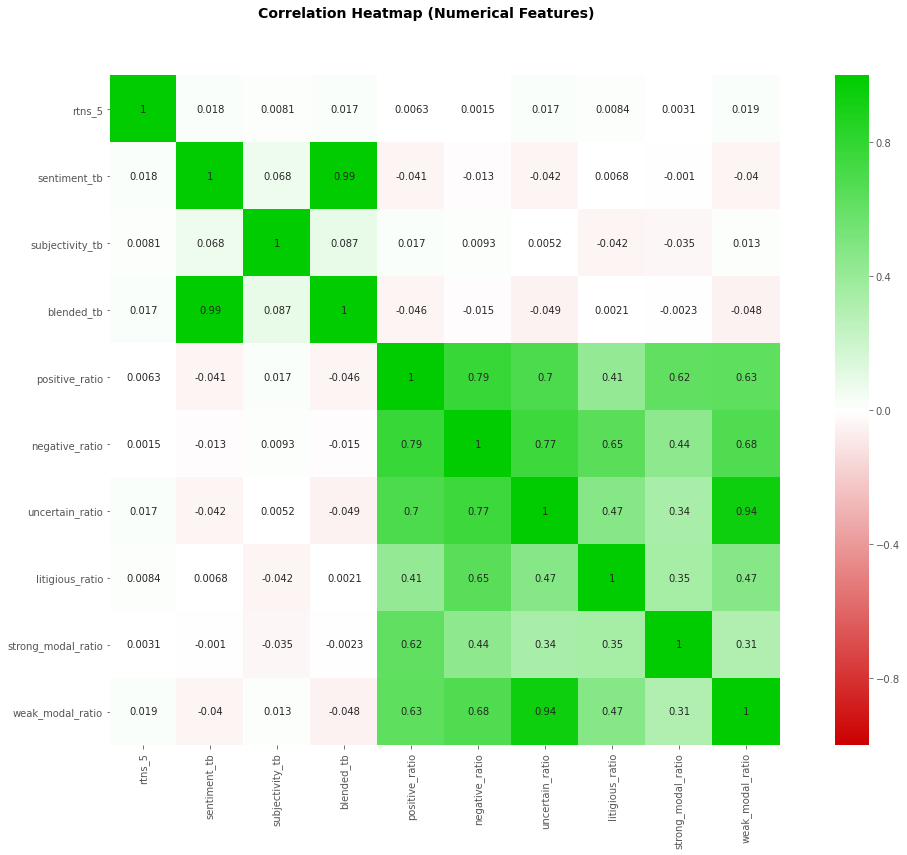

In [111]:
# Prepare the figure
fig = plt.figure(figsize=(20,12))
title = fig.suptitle('Correlation Heatmap (Numerical Features)', fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.9, wspace=0.3)

ax = fig.add_subplot(1,1,1)
sns.heatmap(in_sample_df[num_cols].corr(), norm = DivergingNorm(0),vmin=-1, vmax=1,square=True,annot=True,cmap=GnRd)
plt.show()

<Figure size 1440x1440 with 0 Axes>

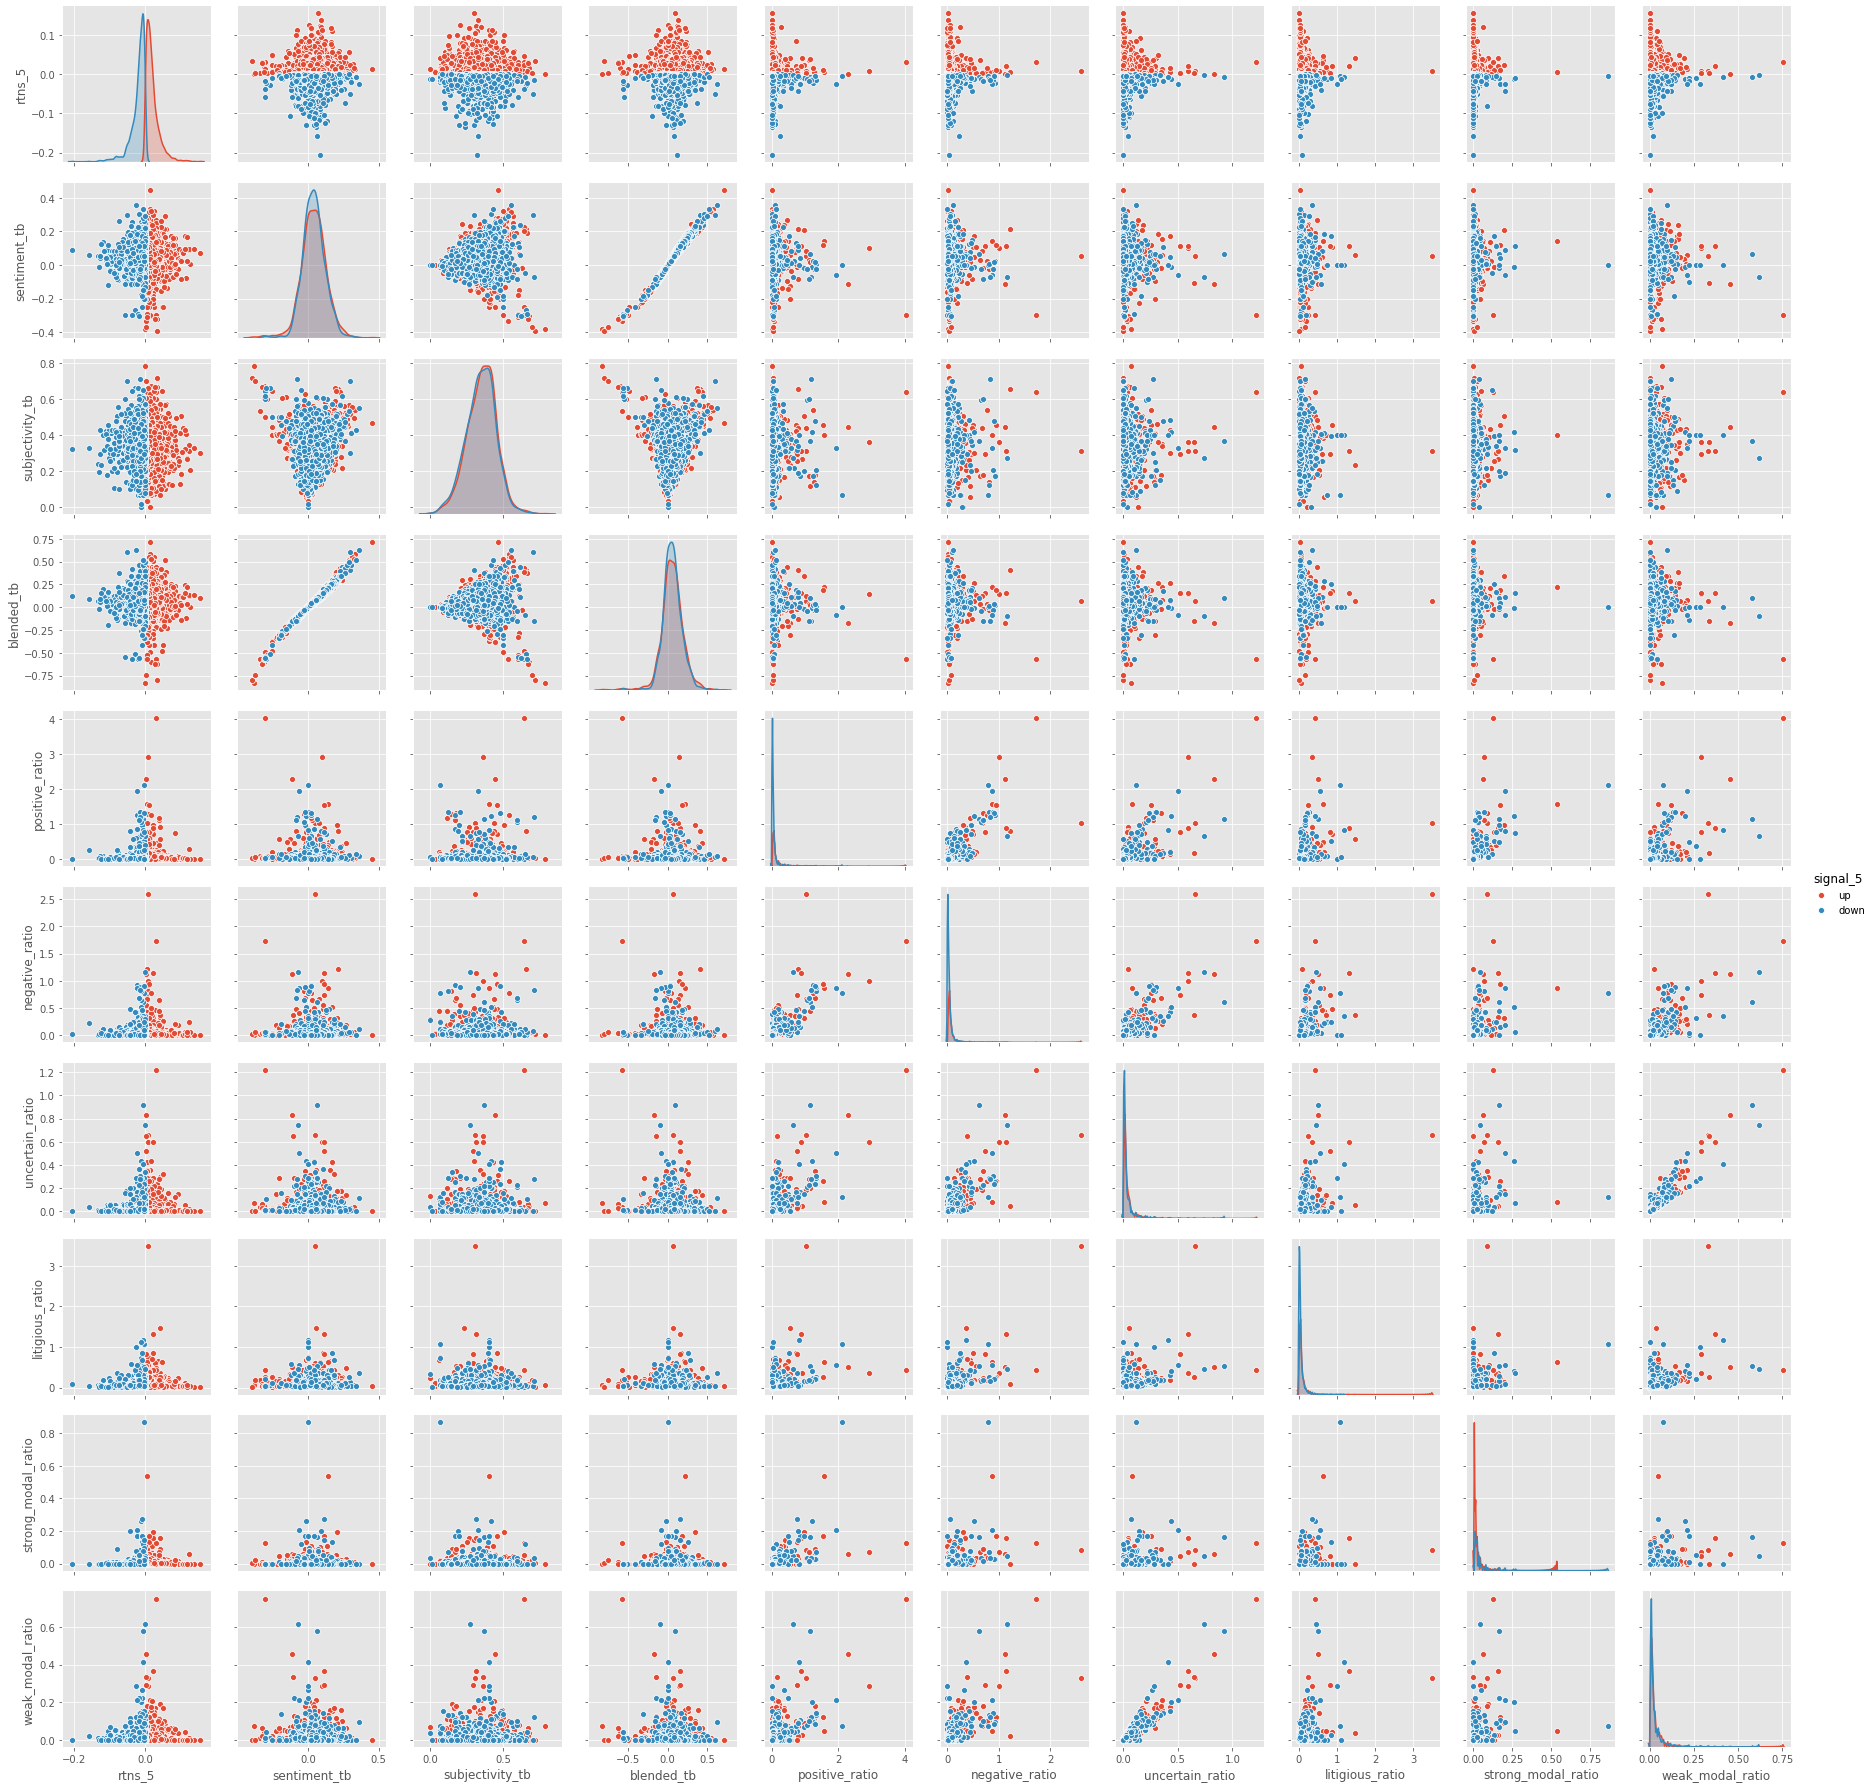

In [112]:
plt.figure(figsize=(20,20))
sns.pairplot(in_sample_df[num_cols + ["signal_5"]],hue="signal_5")
plt.show()


### 4.4 Discretizing Sentiments

In [115]:
def discretize(sentiment_score, in_sample_df, out_sample_df, bin_size=5):
    '''
    Function to discretize numerical features into bins
    Args:
      sentiment_score: A string; name of sentiment
      in_sample_df: A Pandas `dataframe`
      out_sample_df: A Pandas `dataframe`
      bin_size: An integer; width of bin
    Returns:
      Updated in_sample_df and out_sample_df with the respective discretized columns
    '''
    
    def assign_bucket(x, ranges):
        if x <= ranges[0]:
            return 0
        for i in range(1, len(ranges) - 1):
            if x <= ranges[i]:
                return i - 1
        return len(ranges) - 2
    
    _, boundaries = np.histogram(in_sample_df[sentiment_score], bins=bin_size)
    in_sample_df["{}_disc".format(sentiment_score)] = in_sample_df[sentiment_score].apply(lambda x: assign_bucket(x, boundaries))
    out_sample_df['{}_disc'.format(sentiment_score)] = out_sample_df[sentiment_score].apply(lambda x: assign_bucket(x, boundaries))
    
    return (in_sample_df, out_sample_df)

In [116]:
for sentiment_score in sentiment_scores:
    in_sample_df, out_sample_df = discretize(sentiment_score, in_sample_df, out_sample_df)

In [117]:
dis_cols = [col for col in in_sample_df.columns if "_disc" in col]
    

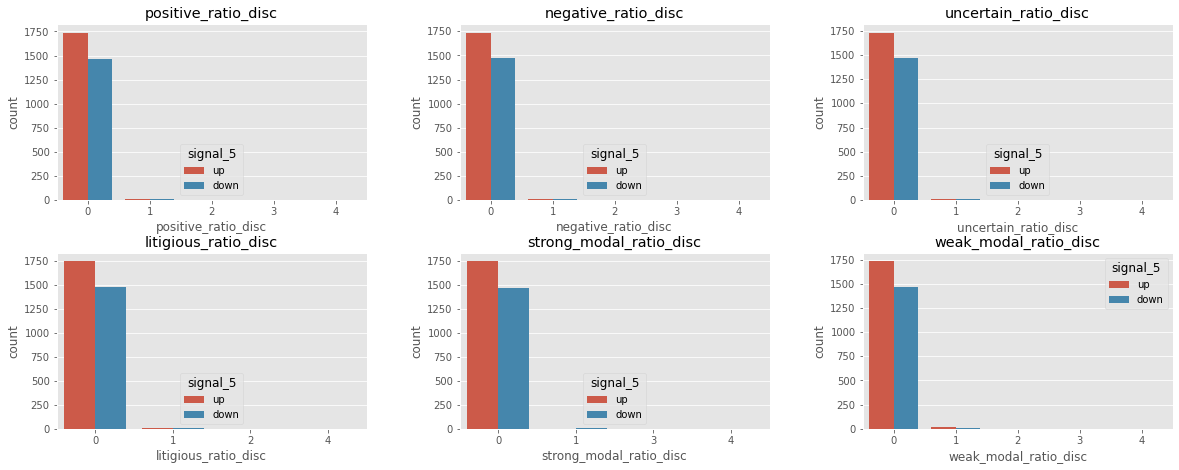

In [118]:
fig = plt.figure(constrained_layout=False, figsize=(20,100))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(dis_cols)):
    axes = fig.add_subplot(spec[i])
    sns.countplot(x=dis_cols[i],hue="signal_5", data=in_sample_df, ax=axes)
    fig.add_subplot(axes)
    axes.title.set_text(dis_cols[i])

fig.show()

### 4.5 Bag of Words and TF-IDF

In [119]:
cv = CountVectorizer(min_df=2, ngram_range=(1, 1))
X_train_dtm_cv = cv.fit_transform(in_sample_df.joined_text_stem)
X_test_dtm_cv = cv.transform(out_sample_df.joined_text_stem)

In [120]:
print(X_train_dtm_cv.shape)
print(X_test_dtm_cv.shape)

(3236, 5194)
(705, 5194)


In [121]:
tf_idf = TfidfVectorizer(min_df=2, ngram_range=(1, 1))
X_train_dtm_tfidf = tf_idf.fit_transform(in_sample_df['joined_text_stem'])
X_test_dtm_tfidf = tf_idf.transform(out_sample_df['joined_text_stem'])



In [122]:
print(X_train_dtm_tfidf.shape)
print(X_test_dtm_tfidf.shape)

(3236, 5194)
(705, 5194)


## 5. Target Distribution (t+5 returns)

### 5.1 Count of Up and Down Signals

In [123]:
in_sample_df["signal_5"].value_counts()

up      1754
down    1482
Name: signal_5, dtype: int64

In [124]:
in_sample_df["signal_5"] = in_sample_df["signal_5"].map(lambda x: 1 if x == "up" else 0)
out_sample_df["signal_5"] = out_sample_df["signal_5"].map(lambda x: 1 if x == "up" else 0)

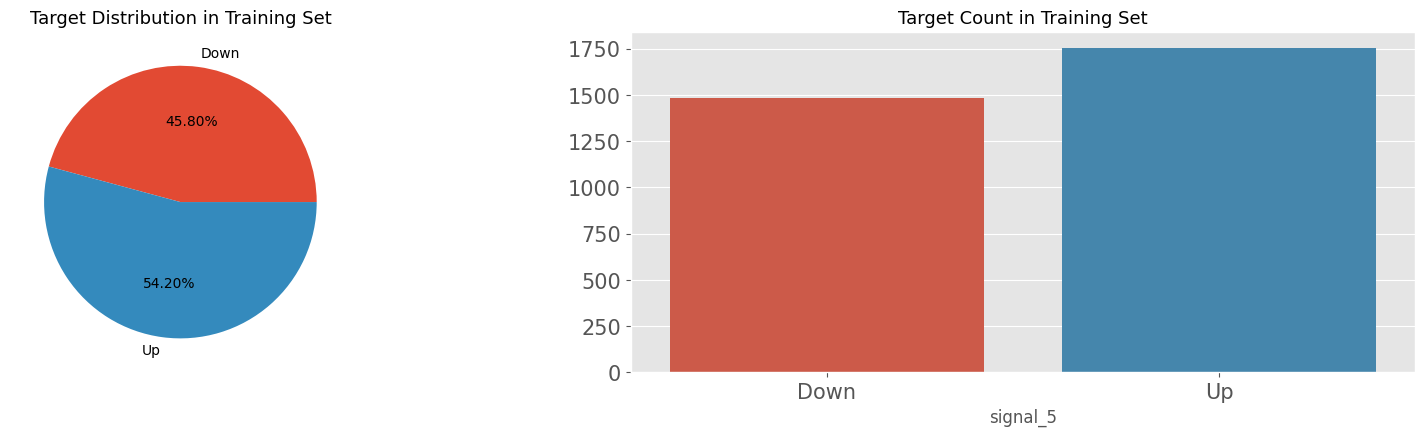

In [125]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

in_sample_df.groupby('signal_5').count()["ticker"].plot(kind='pie', 
                                                    ax=axes[0], 
                                                    labels=['Down', 'Up'],
                                                    autopct = "%.2f%%"
                                                   )
sns.countplot(x=in_sample_df['signal_5'], ax=axes[1], )

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Down', 'Up'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

## 6. Model Building

### 6.1 Standardize Features
- Standard Scaler
- Scale train and test set separately to prevent leaking of information from the test set
- Use the scaler fitted on the train set to scale the test set. This ensures consistency in the transformation and makes it possible to evaluate if the model can generalize well

In [126]:
num_features = [col for col in num_cols if col not in ["rtns_5"]]
cat_features = ["ticker"] + all_events

In [127]:
print(num_features)
print(cat_features)

['sentiment_tb', 'subjectivity_tb', 'blended_tb', 'positive_ratio', 'negative_ratio', 'uncertain_ratio', 'litigious_ratio', 'strong_modal_ratio', 'weak_modal_ratio']
['ticker', "Registrant's Business and Operations", 'Financial Information', 'Securities and Trading Markets', 'Matters Related to Accountants and Financial Statements', 'Corporate Governance and Management', 'Asset-Backed Securities', 'Regulation FD', 'Other Events', 'Financial Statements and Exhibits']


In [128]:
X_train = in_sample_df[cat_features + num_features]
y_train = in_sample_df["signal_5"]
X_test = out_sample_df[cat_features + num_features]
y_test = out_sample_df["signal_5"]

In [129]:
X_train = pd.get_dummies(X_train, columns = ["ticker"], drop_first = True)
X_test = pd.get_dummies(X_test, columns = ["ticker"], drop_first = True)

In [130]:
features = X_train.columns

In [131]:
X_train_scaled = deepcopy(X_train)
X_test_scaled = deepcopy(X_test)

In [132]:
# Normalize features
scaler = StandardScaler()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

In [133]:
X_train_scaled.head()

Registrant's Business and Operations  Financial Information  \
1260                                     0                      0   
1279                                     0                      0   
1278                                     0                      0   
1277                                     0                      1   
1276                                     0                      0   

      Securities and Trading Markets  \
1260                               0   
1279                               0   
1278                               0   
1277                               0   
1276                               0   

      Matters Related to Accountants and Financial Statements  \
1260                                                  0         
1279                                                  0         
1278                                                  0         
1277                                                  0         
1276                                                  0         

      Corporate Governance and Management  Asset-Backed Securities  \
1260                                    1                        0   
1279                                    1                        0   
1278                                    1                        0   
1277                                    0                        0   
1276                                    1                        0   

      Regulation FD  Other Events  Financial Statements and Exhibits  \
1260              0             0                                  1   
1279              0             0                                  1   
1278              0             0                                  0   
1277              0             0                                  1   
1276              0             0                                  0   

      sentiment_tb  ...  ticker_MSFT  ticker_NKE  ticker_PFE  ticker_PG  \
1260      0.152166  ...            0           0           0          0   
1279      1.156816  ...            0           0           0          0   
1278      0.154688  ...            0           0           0          0   
1277      1.487153  ...            0           0           0          0   
1276      0.015582  ...            0           0           0          0   

      ticker_UNH  ticker_UTX  ticker_V  ticker_VZ  ticker_WMT  ticker_XOM  
1260           0           0         0          0           0           0  
1279           0           0         0          0           0           0  
1278           0           0         0          0           0           0  
1277           0           0         0          0           0           0  
1276           0           0         0          0           0           0  

[5 rows x 42 columns]

In [134]:
def cm_and_roc(confusion_matrix, class_names, Y_test, testPredict, figsize = (15,5), fontsize=12):
    '''
    Function to generate confusion matrix and roc curve
    Args:
      confusion_matrix: A confusion matrix 
      class_names: A list of the class names
      Y_test: An array
      testPredict: An array
      figsize: A tuple
      fontsize: An integer
    Returns:
      Plot containing the confusion matrix heatmap and roc curve
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    # Confusion Matrix
    plt.subplot(121)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")
    
    # ROC 
    plt.subplot(122)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_test, testPredict) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.title('Receiver operating characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

### 6.2 Count Vectorizer (XGBoost)

In [135]:
X_train_bow = hstack((X_train_dtm_cv, np.array(X_train_scaled)))

In [136]:
X_test_bow = hstack((X_test_dtm_cv, np.array(X_test_scaled)))

In [137]:
# oversample by SMOTE
sm = SMOTE(random_state=1234)
sm_X_train_bow, sm_y_train_bow = sm.fit_sample(X_train_bow, y_train.ravel())

In [138]:
model_XGB_bow = XGBClassifier(random_state=1234,
                              learning_rate=0.1,
                              min_child_weight=10,
                              gamma=1,
                              subsample=0.7,
                              colsample_bytree=0.6,
                              reg_alpha=0.1,
                              reg_lambda=0.1,
                              max_depth=6,
                              n_estimators=100,
                              eval_metric="auc",
                              tree_method="hist"
                             )

In [139]:
model_XGB_bow.fit(sm_X_train_bow, sm_y_train_bow)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, tree_method='hist', verbosity=1)

In [140]:
y_pred = model_XGB_bow.predict(X_test_bow)

In [141]:
roc_auc_score(y_test, y_pred)

0.474530918054587

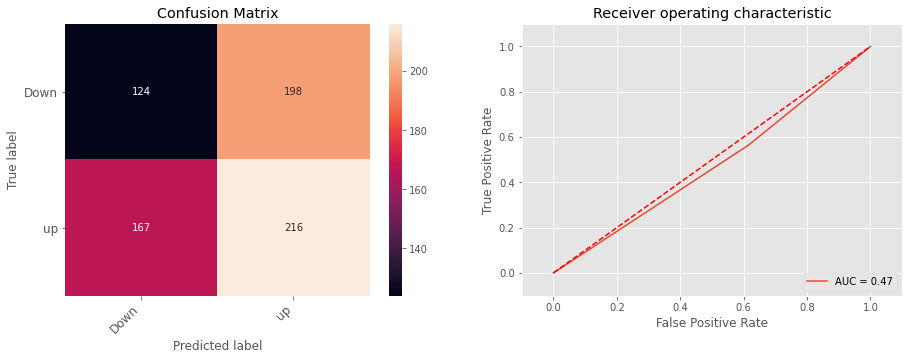

Accuracy:  0.48226950354609927
Sensitivity:  0.5639686684073107
Precision:  0.5217391304347826
f1 Score:  0.5420326223337516
ROC_AUC_Score: 0.474530918054587
MCC:  -0.05153757077066226


In [142]:
cm = confusion_matrix(y_test, y_pred)
cm_and_roc(cm, ["Down", "up"], y_test, y_pred, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred))
print("Sensitivity: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

#### 6.2.1 Breakdown by Ticker Performance

In [143]:
performance = {}
for ticker in sorted(tickers):
    sub_X_test_scaled = X_test_scaled[out_sample_df.ticker == ticker]
    sub_y_test = y_test[out_sample_df.ticker == ticker]
    
    
    sub_X_test_dtm_cv = cv.transform(out_sample_df[out_sample_df.ticker == ticker]["joined_text_stem"])
    
    sub_X_test_bow = hstack((sub_X_test_dtm_cv, np.array(sub_X_test_scaled)))
    sub_y_pred = model_XGB_bow.predict(sub_X_test_bow)
    
    roc_auc = roc_auc_score(sub_y_test, sub_y_pred)
    acc = accuracy_score(sub_y_test, sub_y_pred)
    f1 = f1_score(sub_y_test, sub_y_pred)
    recall = recall_score(sub_y_test, sub_y_pred)
    precision = precision_score(sub_y_test, sub_y_pred)
    
    performance[ticker] = [acc, f1, recall, precision]

In [144]:
metrics_df = pd.DataFrame(performance).T

In [145]:
metrics_df = metrics_df.rename(columns={0:"accuracy", 1:"f1", 2:"recall", 3:"precision"})

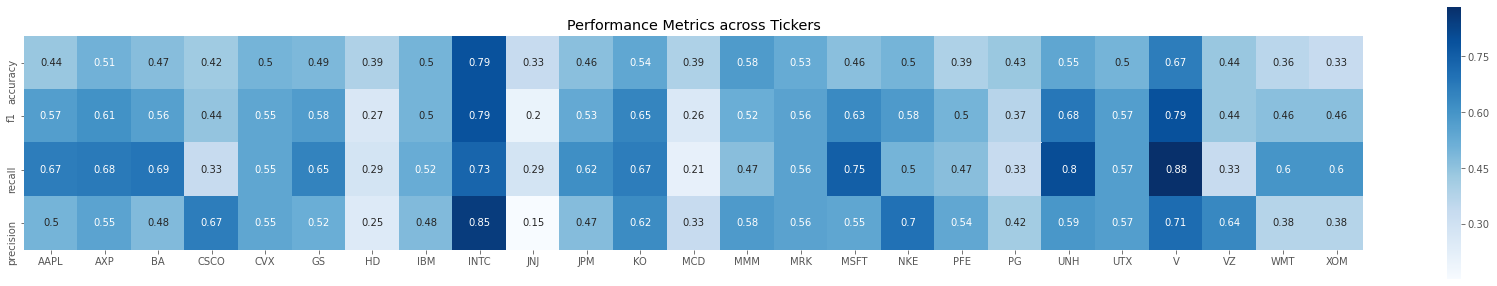

In [146]:
plt.figure(figsize=(30,5))
sns.heatmap(metrics_df.T, square=True,annot=True,cmap="Blues", linecolor='white')
plt.title('Performance Metrics across Tickers')
plt.show()

#### 6.2.2 Save prediction probabilities

In [147]:
y_pred_train = model_XGB_bow.predict_proba(X_train_bow)[:,1]
train_predictions_XGB_bow = in_sample_df[["ticker", "date"]]
train_predictions_XGB_bow["pred"] = y_pred_train

In [148]:
y_pred_test = model_XGB_bow.predict_proba(X_test_bow)[:,1]
test_predictions_XGB_bow = out_sample_df[["ticker", 'date']]
test_predictions_XGB_bow["pred"] = y_pred_test

In [149]:
train_predictions_XGB_bow.head()

ticker       date      pred
1260   AAPL 2014-06-06  0.565478
1279   AAPL 2015-12-22  0.327041
1278   AAPL 2015-12-17  0.560613
1277   AAPL 2015-10-27  0.692519
1276   AAPL 2015-10-02  0.429162

### 6.3 Tfidif (XGBoost)

In [150]:
X_train_tfidf = hstack((X_train_dtm_tfidf, np.array(X_train_scaled)))

In [151]:
X_test_tfidf = hstack((X_test_dtm_tfidf, np.array(X_test_scaled)))

In [152]:
# oversample by SMOTE
sm = SMOTE(random_state=1234)
sm_X_train_tfidf, sm_y_train_tfidf = sm.fit_sample(X_train_tfidf, y_train.ravel())

In [153]:
model_XGB_tfidf = XGBClassifier(random_state=1234,
                                learning_rate=0.1,
                                min_child_weight=10,
                                gamma=1,
                                subsample=0.7,
                                colsample_bytree=0.6,
                                reg_alpha=0.1,
                                reg_lambda=0.1,
                                max_depth=6,
                                n_estimators=100,
                                eval_metric="auc",
                                tree_method="hist"
                               )

In [154]:
model_XGB_tfidf.fit(sm_X_train_tfidf, sm_y_train_tfidf, verbose=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, tree_method='hist', verbosity=1)

In [155]:
y_pred = model_XGB_tfidf.predict(X_test_tfidf)

In [156]:
roc_auc_score(y_test, y_pred)

0.5104519728200057

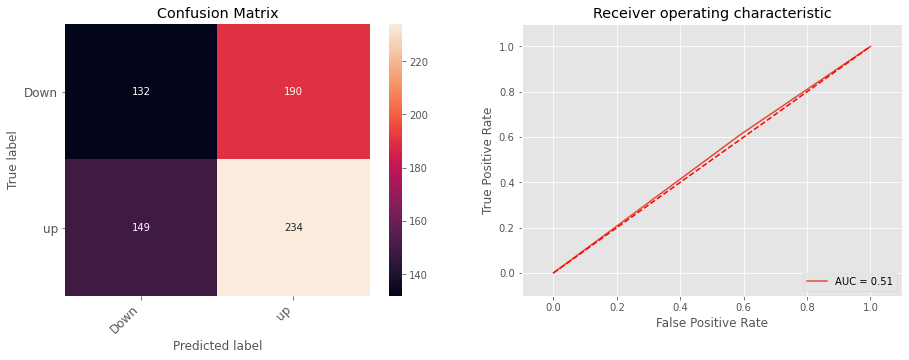

Accuracy:  0.5191489361702127
Sensitivity:  0.6109660574412533
Precision:  0.5518867924528302
f1 Score:  0.5799256505576209
ROC_AUC_Score: 0.5104519728200057
MCC:  0.021267649871919765


In [157]:
cm = confusion_matrix(y_test, y_pred)
cm_and_roc(cm, ["Down", "up"], y_test, y_pred, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred))
print("Sensitivity: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

#### 6.3.1 Breakdown by Ticker Peformance

In [158]:
performance = {}
for ticker in sorted(tickers):
    sub_X_test_scaled = X_test_scaled[out_sample_df.ticker == ticker]
    sub_y_test = y_test[out_sample_df.ticker == ticker]
    
    
    sub_X_test_dtm_tfidf = tf_idf.transform(out_sample_df[out_sample_df.ticker == ticker]["joined_text_lemm"])
    
    sub_X_test_tfidf = hstack((sub_X_test_dtm_tfidf, np.array(sub_X_test_scaled)))
    sub_y_pred = model_XGB_tfidf.predict(sub_X_test_tfidf)
    
    roc_auc = roc_auc_score(sub_y_test, sub_y_pred)
    acc = accuracy_score(sub_y_test, sub_y_pred)
    f1 = f1_score(sub_y_test, sub_y_pred)
    recall = recall_score(sub_y_test, sub_y_pred)
    precision = precision_score(sub_y_test, sub_y_pred)
    
    performance[ticker] = [acc, f1, recall, precision]

In [159]:
metrics_df = pd.DataFrame(performance).T

In [160]:
metrics_df = metrics_df.rename(columns={0:"accuracy", 1:"f1", 2:"recall", 3:"precision"})

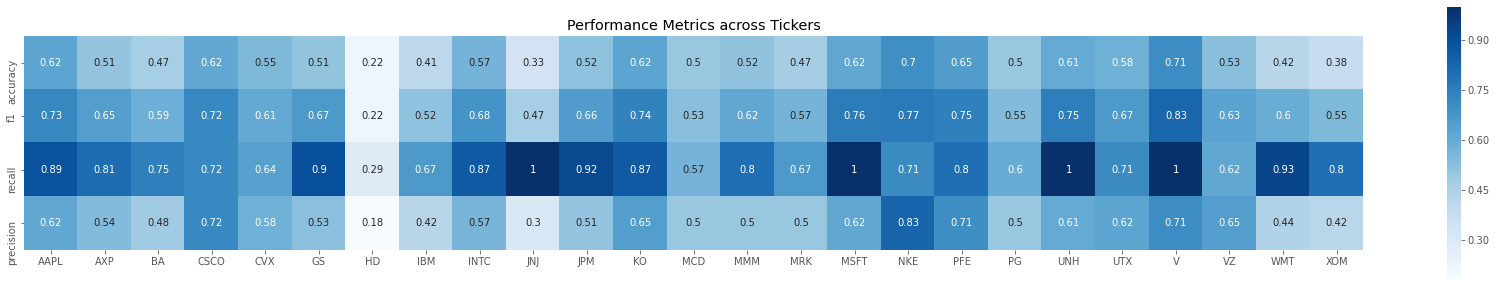

In [161]:
plt.figure(figsize=(30,5))
sns.heatmap(metrics_df.T, square=True,annot=True,cmap="Blues", linecolor='white')
plt.title('Performance Metrics across Tickers')
plt.show()

#### 6.2.2 Save prediction probabilities

In [162]:
y_pred_train = model_XGB_tfidf.predict_proba(X_train_tfidf)[:,1]
train_predictions_XGB_tfidf = in_sample_df[["ticker", "date"]]
train_predictions_XGB_tfidf["pred"] = y_pred_train

In [163]:
y_pred_test = model_XGB_bow.predict_proba(X_test_tfidf)[:,1]
test_predictions_XGB_tfidf = out_sample_df[["ticker", 'date']]
test_predictions_XGB_tfidf["pred"] = y_pred_test

In [164]:
train_predictions_XGB_tfidf.head()

ticker       date      pred
1260   AAPL 2014-06-06  0.690796
1279   AAPL 2015-12-22  0.445275
1278   AAPL 2015-12-17  0.527820
1277   AAPL 2015-10-27  0.717853
1276   AAPL 2015-10-02  0.555450

### 6.4 Word Embeddings - GloVe

Global Vectors for Word Representation, or GloVe, is an “unsupervised learning algorithm for obtaining vector representations for words.” Simply put, GloVe allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space. This means that similar words will be placed together.

https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

https://nlp.stanford.edu/projects/glove/

In [165]:
NUM_PARALLEL_EXEC_UNITS = multiprocessing.cpu_count()
config = tf.ConfigProto(
    device_count={"CPU": NUM_PARALLEL_EXEC_UNITS},
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    allow_soft_placement=True
)
session = tf.Session(config=config)
K.set_session(session)

In [166]:
in_sample_df.joined_text_lemm.map(len).describe()

count      3236.000000
mean       3568.610012
std        9994.209098
min         155.000000
25%        1145.000000
50%        1736.000000
75%        2949.750000
max      324064.000000
Name: joined_text_lemm, dtype: float64

In [167]:
#### Define number of words, and embedding dimensions
max_words = 3000
embed_dim = 100

def load_embeddings(vec_file):
    '''
    Function to load word embeddings
    Args:
      vec_file: Directory to the word embeddings file
    Returns:
      A dictionary of the word embeddings
    '''
    print("Loading Glove Model")
    f = open(vec_file,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done. {} words loaded!".format(len(model)))
    return model

def tokenize_and_pad(docs_train, docs_test, max_words=max_words):
    '''
    Function to tokenize the text and then pad the sequence
    Args:
      docs_train: A Pandas Series; 8-K Documents from train set
      docs_test: A Pandas Series; 8-K Documents from test set
      max_words: An integer; The maximum number of words in the sequence
    Returns:
      A tuple containing (1) padded docs_train (2) padded docs_test (3) number of unique words (4) tokenizer
    '''
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(docs_train)
    list_tokenized_train = tokenizer.texts_to_sequences(docs_train)
    list_tokenized_test = tokenizer.texts_to_sequences(docs_test)
    docs_train = pad_sequences(list_tokenized_train, maxlen=max_words, padding="post")
    docs_test = pad_sequences(list_tokenized_test, maxlen=max_words, padding="post")
    vocab_size = len(tokenizer.word_index) + 1
    
    return (docs_train, docs_test, vocab_size, tokenizer)


In [168]:
docs_train = in_sample_df["processed_text_lemm"]
docs_test = out_sample_df["processed_text_lemm"]

In [169]:
docs_train, docs_test, vocab_size, tokenizer = tokenize_and_pad(docs_train, docs_test)

In [170]:
embeddings_index = load_embeddings("glove.6B/glove.6B.100d.txt")


Loading Glove Model
Done. 400000 words loaded!


In [171]:
aux_shape = len(X_train_scaled.columns)

In [172]:
words_not_found = []

embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 405


In [173]:
def build_model(vocab_size=vocab_size, embed_dim=embed_dim, embedding_matrix=embedding_matrix, max_seq_len=max_words):
    '''
    Function to create a CNN-Bidirectional LSTM network
    Args:
      vocab_size: An integer; the number of unique words
      embed_dim: An integer; the dimension of the word vector represetnation
      embedding_matrix: A matrix of the word vectors
      max_seq_len: An integer, the maximum number of words
    Returns:
      A CNN-Bidrectional LSTM network
    '''
    
    main_input = Input(shape=(max_seq_len,), name='doc_input')
    main = Embedding(input_dim = vocab_size,
                     output_dim = embed_dim,
                     weights=[embedding_matrix],
                     input_length=max_seq_len
                    )(main_input)
    main = Conv1D(64, 5, padding="same", activation="relu")(main)
    main = MaxPooling1D()(main)
    main = Dropout(0.2)(main)
    main = Bidirectional(LSTM(32, return_sequences=False), merge_mode="concat")(main)
    main = BatchNormalization()(main)

    auxiliary_input = Input(shape=(aux_shape,), name='aux_input')
    x = lconcat([main, auxiliary_input])
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [174]:
combined_train = pd.DataFrame(docs_train).join(X_train_scaled.reset_index().drop("index", axis=1))

In [175]:
combined_train.shape

(3236, 3042)

In [176]:
sm = SMOTE(random_state=1234)
sm_X_train_dl, sm_y_train_dl = sm.fit_sample(combined_train, y_train.ravel())

In [177]:
with session.as_default():
    with session.graph.as_default():
        np.random.seed(1234)
        model = build_model()
        model.fit([sm_X_train_dl[:,:3000], sm_X_train_dl[:,3000:]], 
                  sm_y_train_dl,
                  batch_size=512,
                  validation_split=0.1,
                  epochs=10,
                  verbose=1
                 )







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3157 samples, validate on 351 samples
Epoch 1/10
3157/3157 [==============================] - 67s 21ms/step - loss: 0.6969 - acc: 0.5163 - val_loss: 0.7315 - val_acc: 0.2137
Epoch 2/10
3157/3157 [==============================] - 58s 18ms/step - loss: 0.6880 - acc: 0.5360 - val_loss: 0.7345 - val_acc: 0.2678
Epoch 3/10
3157/3157 [==============================] - 56s 18ms/step - loss: 0.6842 - acc: 0.5496 - val_loss: 0.7301 - val_acc: 0.2764
Epoch 4/10
3157/3157 [==============================] - 50s 16ms/step - loss: 0.6817 - acc: 0.5600 - val_loss: 0.7188 - val_acc: 0.3590
Epoch 5/10
3157/3157 [==============================] - 51s 16ms/step - loss: 0.6798 - acc: 0.5489 - val_loss: 0.6979 - val_acc: 0.4729
Epoch 6/10
3157/3157 [==============================] - 5

In [178]:
y_pred_dl = model.predict([docs_test, X_test_scaled], batch_size=1024, verbose=1)

705/705 [==============================] - 5s 7ms/step


In [179]:
y_pred_dl = list(map(lambda x:x[0], y_pred_dl))

In [180]:
y_pred_dl = list(map(lambda x: 1 if x > 0.5 else 0, y_pred_dl))

In [181]:
roc_auc_score(y_test, y_pred_dl)

0.4863370254447562

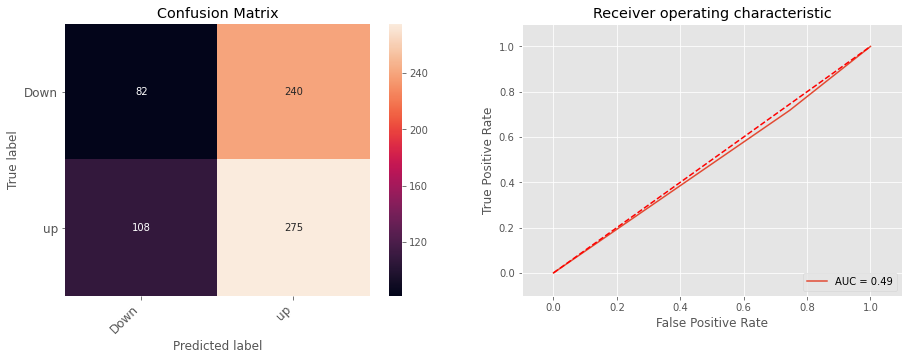

Accuracy:  0.5063829787234042
Sensitivity:  0.7180156657963447
Precision:  0.5339805825242718
f1 Score:  0.6124721603563474
ROC_AUC_Score: 0.4863370254447562
MCC:  -0.03067765528024502


In [182]:
cm = confusion_matrix(y_test, y_pred_dl)
cm_and_roc(cm, ["Down", "up"], y_test, y_pred_dl, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_dl))
print("Sensitivity: ", recall_score(y_test, y_pred_dl))
print("Precision: ", precision_score(y_test, y_pred_dl))
print ("f1 Score: ", f1_score(y_test, y_pred_dl))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_dl))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dl))

#### 6.4.1 Breakdown by Ticker Peformance

In [183]:
performance = {}
for ticker in sorted(tickers):
    sub_X_test_scaled = X_test_scaled[out_sample_df.ticker == ticker]
    sub_y_test = y_test[out_sample_df.ticker == ticker]
    
    sub_docs_test = out_sample_df[out_sample_df.ticker == ticker]["processed_text_lemm"]
    sub_list_tokenized_test = tokenizer.texts_to_sequences(sub_docs_test)
    sub_docs_test = pad_sequences(sub_list_tokenized_test, maxlen=max_words, padding="post")
    
    sub_y_pred = model.predict([sub_docs_test, sub_X_test_scaled], batch_size=32, verbose=1)
    sub_y_pred = list(map(lambda x:1 if x[0] > 0.5 else 0, sub_y_pred))
    
    roc_auc = roc_auc_score(sub_y_test, sub_y_pred)
    acc = accuracy_score(sub_y_test, sub_y_pred)
    f1 = f1_score(sub_y_test, sub_y_pred)
    recall = recall_score(sub_y_test, sub_y_pred)
    precision = precision_score(sub_y_test, sub_y_pred)
    
    performance[ticker] = [acc, f1, recall, precision]

21/21 [==============================] - 0s 6ms/step


In [184]:
metrics_df = pd.DataFrame(performance).T

In [185]:
metrics_df = metrics_df.rename(columns={0:"accuracy", 1:"f1", 2:"recall", 3:"precision"})

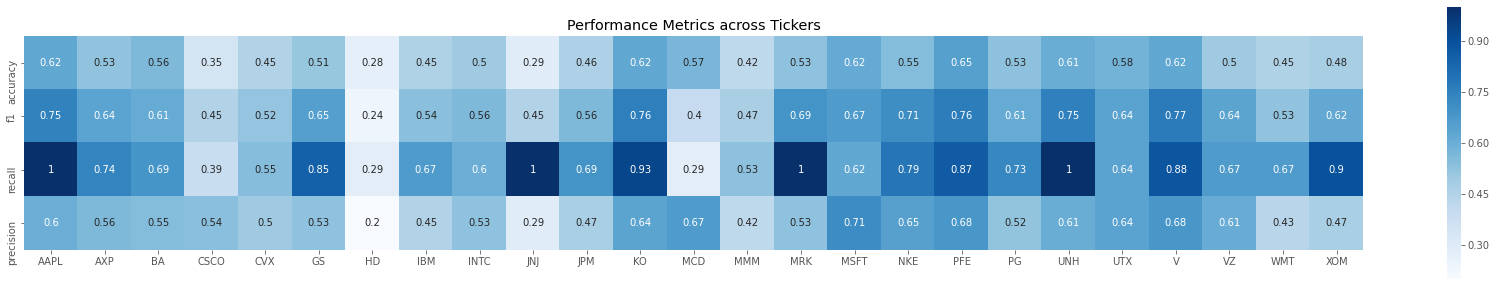

In [186]:
plt.figure(figsize=(30,5))
sns.heatmap(metrics_df.T, square=True,annot=True,cmap="Blues", linecolor='white')
plt.title('Performance Metrics across Tickers')
plt.show()

#### 6.3.2 Save prediction probabilities

In [187]:
y_pred_train = model.predict([docs_train, X_train_scaled], batch_size=1024, verbose=1)[:,0]
train_predictions_dl = in_sample_df[["ticker", "date"]]
train_predictions_dl["pred"] = y_pred_train

3236/3236 [==============================] - 8s 3ms/step


In [188]:
y_pred_test = model.predict([docs_test, X_test_scaled], batch_size=1024, verbose=1)[:,0]
test_predictions_dl = out_sample_df[["ticker", 'date']]
test_predictions_dl["pred"] = y_pred_test

705/705 [==============================] - 2s 2ms/step


In [189]:
train_predictions_dl.head()

ticker       date      pred
1260   AAPL 2014-06-06  0.568585
1279   AAPL 2015-12-22  0.460784
1278   AAPL 2015-12-17  0.512708
1277   AAPL 2015-10-27  0.542310
1276   AAPL 2015-10-02  0.513894

### 6.5 Model Stacking 
- Combining XGB_BOW, XGB_TFIDF and Neural Nets

In [190]:
train_predictions_final = train_predictions_dl[["ticker", "date"]] 
test_predictions_final = test_predictions_dl[["ticker", "date"]]

In [191]:
train_predictions_final["pred_XGB_bow"] = train_predictions_XGB_bow.pred.values
train_predictions_final["pred_XGB_tfidf"] = train_predictions_XGB_tfidf.pred.values
train_predictions_final["pred_dl"] = train_predictions_dl.pred.values


test_predictions_final["pred_XGB_bow"] = test_predictions_XGB_bow.pred.values
test_predictions_final["pred_XGB_tfidf"] = test_predictions_XGB_tfidf.pred.values
test_predictions_final["pred_dl"] = test_predictions_dl.pred.values


In [192]:
train_predictions_final["pred_final"] = train_predictions_final[["pred_XGB_bow", "pred_XGB_tfidf", "pred_dl"]].mean(axis=1)
test_predictions_final["pred_final"] = test_predictions_final[["pred_XGB_bow", "pred_XGB_tfidf", "pred_dl"]].mean(axis=1)


In [193]:
train_predictions_final["pred_final"] = train_predictions_final["pred_final"].map(lambda x: 1 if x > 0.5 else 0)
test_predictions_final["pred_final"] = test_predictions_final["pred_final"].map(lambda x: 1 if x > 0.5 else 0)

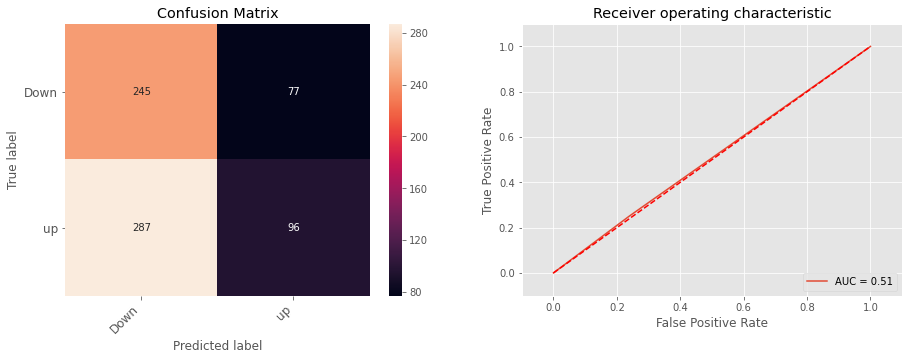

Accuracy:  0.4836879432624113
Sensitivity:  0.2506527415143603
Precision:  0.5549132947976878
f1 Score:  0.34532374100719426
ROC_AUC_Score: 0.5057611533658758
MCC:  0.013337913217744185


In [194]:
y_pred_stack = test_predictions_final.pred_final.values
cm = confusion_matrix(y_test, y_pred_stack)
cm_and_roc(cm, ["Down", "up"], y_test, y_pred_stack, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_stack))
print("Sensitivity: ", recall_score(y_test, y_pred_stack))
print("Precision: ", precision_score(y_test, y_pred_stack))
print ("f1 Score: ", f1_score(y_test, y_pred_stack))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_stack))
print("MCC: ", matthews_corrcoef(y_test, y_pred_stack))

#### 6.5.1 Breakdown by Ticker Performance

In [195]:
performance = {}
for ticker in sorted(tickers):
    sub_y_pred = test_predictions_final[test_predictions_final.ticker == ticker]["pred_final"].values
    sub_y_test = y_test[out_sample_df.ticker == ticker]
    
    roc_auc = roc_auc_score(sub_y_test, sub_y_pred)
    acc = accuracy_score(sub_y_test, sub_y_pred)
    f1 = f1_score(sub_y_test, sub_y_pred)
    recall = recall_score(sub_y_test, sub_y_pred)
    precision = precision_score(sub_y_test, sub_y_pred)
    
    performance[ticker] = [roc_auc, acc, f1, recall, precision]

In [196]:
metrics_df = pd.DataFrame(performance).T

In [197]:
metrics_df = metrics_df.rename(columns={0:"roc_auc", 1:"accuracy", 2:"f1", 3:"recall", 4:"precision"})

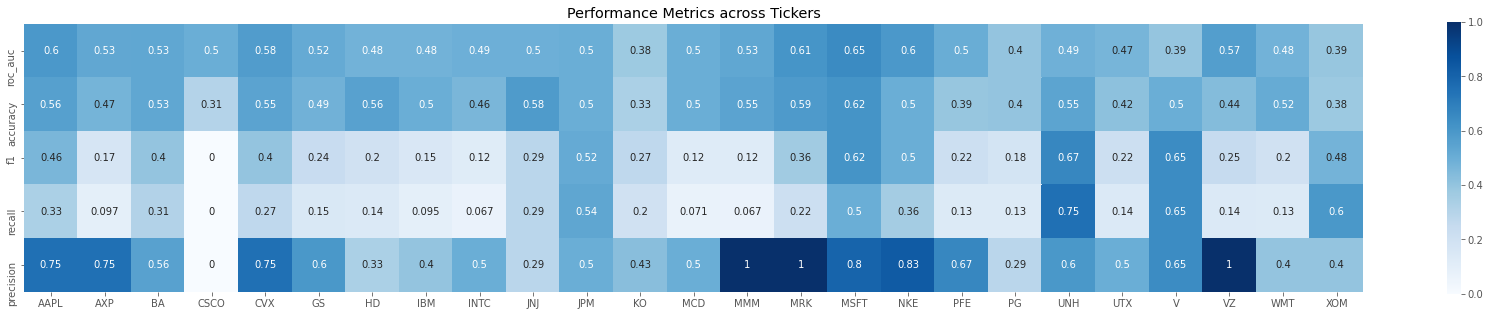

In [198]:
plt.figure(figsize=(30,5))
sns.heatmap(metrics_df.T, square=True,annot=True,cmap="Blues", linecolor='white')
plt.title('Performance Metrics across Tickers')
plt.show()

**Observation:** Stacking the models give poorer results.

### 6.6 Save Final Model (Train and Test Predictions)
- Best model is XGBoost with TFIDF Features

In [199]:
y_pred_train = model_XGB_tfidf.predict(X_train_tfidf)
train_predictions = in_sample_df[["ticker", "date"]]
train_predictions["pred"] = y_pred_train

In [200]:
y_pred_test = model_XGB_tfidf.predict(X_test_tfidf)
test_predictions = out_sample_df[["ticker", 'date']]
test_predictions["pred"] = y_pred_test

In [201]:
def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Obtain stocks information (Date, OHLC, Volume and Adjusted Close). 
    Uses Pandas DataReader to make an API Call to Yahoo Finance and download the data directly.
    Computes other values - Log Return and Arithmetic Return.
    
    Input: List of Stock Tickers
    Output: A dictionary of dataframes for each stock
    '''
    stocks = dict()
    for ticker in tickers:
        s = DataReader(ticker, 'yahoo', start_date, end_date)
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        s['Date'] = pd.to_datetime(s.index) #useful for transformation later
        s['Prev Adj Close'] = s['Adj Close'].shift(1)
        s['Log Return'] = np.log(s['Adj Close']/s['Prev Adj Close'])
        s['Return'] = (s['Adj Close']/s['Prev Adj Close']-1)
        s = s.reset_index(drop=True)
        
        cols = list(s.columns.values) # re-arrange columns
        cols.remove("Date")
        s = s[["Date"] + cols]
        s["Date"] = pd.to_datetime(s["Date"])
        s = s.set_index("Date")
        
        stocks[ticker] = s
        
    return stocks

In [202]:
stock_data = get_data_for_multiple_stocks(tickers, "2010-01-01", "2019-12-31")

In [203]:
for ticker in tickers:
    ticker_train = stock_data[ticker][["Ticker", "Log Return"]].loc["2010-01-01":"2018-01-01",]
    ticker_test = stock_data[ticker][["Ticker", "Log Return"]].loc["2018-01-01":]
    
    ticker_train_pred = train_predictions[train_predictions.ticker == ticker]
    ticker_train_pred = ticker_train_pred.set_index("date")
    ticker_train_pred.pred = ticker_train_pred.pred.map(lambda x:1 if x == 1 else -1)
    ticker_train_final = ticker_train.join(ticker_train_pred["pred"])
    ticker_train_final[ticker] = ticker_train_final["pred"].fillna(method="ffill", limit=5-1)
    ticker_train_final[ticker] = ticker_train_final[ticker].fillna(0)
    ticker_train_final[ticker] = ticker_train_final[ticker].map(int)
    ticker_train_final = ticker_train_final[[ticker]]
    
    
    ticker_test_pred = test_predictions[test_predictions.ticker == ticker]
    ticker_test_pred = ticker_test_pred.set_index("date")
    ticker_test_pred.pred = ticker_test_pred.pred.map(lambda x:1 if x == 1 else -1)
    ticker_test_final = ticker_test.join(ticker_test_pred["pred"])
    ticker_test_final[ticker] = ticker_test_final["pred"].fillna(method="ffill", limit=5-1)
    ticker_test_final[ticker] = ticker_test_final[ticker].fillna(0)
    ticker_test_final[ticker] = ticker_test_final[ticker].map(int)
    ticker_test_final = ticker_test_final[[ticker]]
    
    
    ticker_train_final.to_csv("../../Predictions/8K SEC/{}_train_8K.csv".format(ticker))
    ticker_test_final.to_csv("../../Predictions/8K SEC/{}_test_8K.csv".format(ticker))
    

In [204]:
K.clear_session()
tf.reset_default_graph()

## 7. Model Interpretation

In [206]:
t0 = time.time()
explainer = shap.TreeExplainer(model_XGB_tfidf)
shap_values_train = explainer.shap_values(X_train_tfidf)
t1 = time.time()
timeit = t1-t0
print('time to compute Shapley values (s):', timeit)

time to compute Shapley values (s): 0.9777910709381104


In [207]:
txt_dense_df = pd.DataFrame(X_train_tfidf.todense(), columns=cv.get_feature_names() + list(X_train_scaled.columns))
shap_values_train_df = pd.DataFrame(shap_values_train, columns=txt_dense_df.columns)


In [208]:
shap_values_train_df

aal  aam  aba  abacus  abandon  abb  abe  abi  abid  abil  ...  \
0     0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
1     0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
2     0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
3     0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
4     0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
...   ...  ...  ...     ...      ...  ...  ...  ...   ...   ...  ...   
3231  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
3232  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
3233  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
3234  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   
3235  0.0  0.0  0.0     0.0      0.0  0.0  0.0  0.0   0.0   0.0  ...   

      ticker_MSFT  ticker_NKE  ticker_PFE  ticker_PG  ticker_UNH  ticker_UTX  \
0             0.0         0.0         0.0        0.0   -0.003638         0.0   
1             0.0         0.0         0.0        0.0   -0.003602         0.0   
2             0.0         0.0         0.0        0.0   -0.003664         0.0   
3             0.0         0.0         0.0        0.0   -0.003664         0.0   
4             0.0         0.0         0.0        0.0   -0.003664         0.0   
...           ...         ...         ...        ...         ...         ...   
3231          0.0         0.0         0.0        0.0   -0.004335         0.0   
3232          0.0         0.0         0.0        0.0   -0.003602         0.0   
3233          0.0         0.0         0.0        0.0   -0.003638         0.0   
3234          0.0         0.0         0.0        0.0   -0.003638         0.0   
3235          0.0         0.0         0.0        0.0   -0.003638         0.0   

      ticker_V  ticker_VZ  ticker_WMT  ticker_XOM  
0          0.0   0.004085         0.0         0.0  
1          0.0   0.001851         0.0         0.0  
2          0.0   0.004046         0.0         0.0  
3          0.0   0.001813         0.0         0.0  
4          0.0   0.004046         0.0         0.0  
...        ...        ...         ...         ...  
3231       0.0   0.004046         0.0         0.0  
3232       0.0   0.001851         0.0         0.0  
3233       0.0   0.004046         0.0         0.0  
3234       0.0   0.001851         0.0         0.0  
3235       0.0   0.004046         0.0         0.0  

[3236 rows x 5236 columns]

In [209]:
shap_sum = np.abs(shap_values_train_df).mean(axis=0)

In [210]:
importance_df = pd.DataFrame([txt_dense_df.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["column_name", "shap_importance (log-odds)"]
importance_df = importance_df.sort_values('shap_importance (log-odds)', ascending=False)
importance_df['shap_importance (%)'] = importance_df['shap_importance (log-odds)'].apply(lambda x: 100 *x/np.sum(importance_df['shap_importance (log-odds)']))


In [211]:
topN = 20
top20 = importance_df.iloc[0:topN]["column_name"]

print('Cumulative Importance', np.sum(importance_df.iloc[0:topN]["shap_importance (%)"]))

importance_df.iloc[0:topN]

Cumulative Importance 18.357342330452134


column_name shap_importance (log-odds)  shap_importance (%)
962             corpor                  0.0474079             1.316731
5206    positive_ratio                  0.0415577             1.154246
5211  weak_modal_ratio                  0.0403964             1.121991
281             assist                  0.0372782             1.035384
587               busi                  0.0367757             1.021428
606             calcul                  0.0349892             0.971809
3803            report                  0.0343398             0.953773
3496             prior                  0.0340373             0.945369
1326              duli                  0.0339742             0.943618
1771              from                  0.0329179             0.914280
419             behalf                  0.0321979             0.894280
3150           opinion                  0.0320101             0.889066
5204   subjectivity_tb                  0.0306494             0.851272
2588             lower                  0.0294062             0.816742
2906              most                  0.0287203             0.797693
2311              item                  0.0279654             0.776725
1322               due                  0.0277484             0.770698
2179           increas                  0.0262807             0.729933
4361           subject                  0.0261879             0.727357
5207    negative_ratio                  0.0261011             0.724946

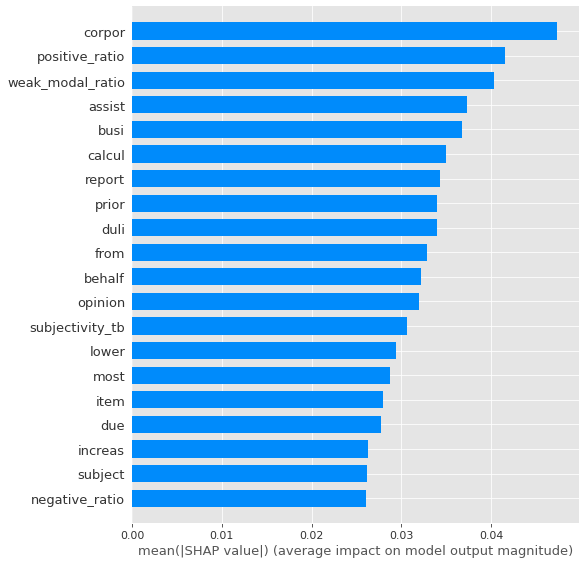

In [212]:
shap.summary_plot(shap_values_train_df, txt_dense_df, plot_type="bar")


In [213]:
shap_values_imp = shap_values_train_df[top20]
shap_values_imp.head()

corpor  positive_ratio  weak_modal_ratio    assist      busi    calcul  \
0 -0.029594       -0.051781         -0.031749  0.056094  0.017962  0.025566   
1 -0.148991        0.011494          0.001553  0.043289  0.130324  0.015830   
2  0.032595        0.012885         -0.032888  0.018579  0.021869  0.026538   
3  0.052961        0.077214         -0.012313  0.036165  0.014249  0.024466   
4  0.056069        0.027999         -0.026337  0.042116  0.026369  0.026169   

     report     prior      duli      from    behalf   opinion  \
0  0.063591  0.022605 -0.026742 -0.088601  0.006566  0.016231   
1  0.042413  0.023269 -0.026229  0.008002 -0.006043  0.011972   
2 -0.147129  0.024188 -0.034544  0.008253 -0.020175  0.010194   
3  0.019050  0.036509  0.009746 -0.037330  0.086786  0.009897   
4 -0.117261  0.024395 -0.034544  0.018553  0.000039  0.009864   

   subjectivity_tb     lower      most      item       due   increas  \
0         0.040525  0.016666  0.011462 -0.013577  0.012057  0.016550   
1         0.036666  0.012943  0.010359 -0.009985  0.018370  0.016310   
2         0.013378  0.017290  0.021425  0.019254  0.020882  0.015113   
3         0.019062  0.015730  0.005310 -0.023813  0.037895  0.015601   
4         0.007586  0.020035  0.017844 -0.039110  0.028455  0.014526   

    subject  negative_ratio  
0 -0.000976        0.005626  
1  0.007171       -0.005906  
2 -0.003830        0.001461  
3  0.021193        0.016145  
4 -0.002391       -0.019373

In [214]:
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values_imp.iloc[0].to_numpy(), 
                txt_dense_df.iloc[0][top20])

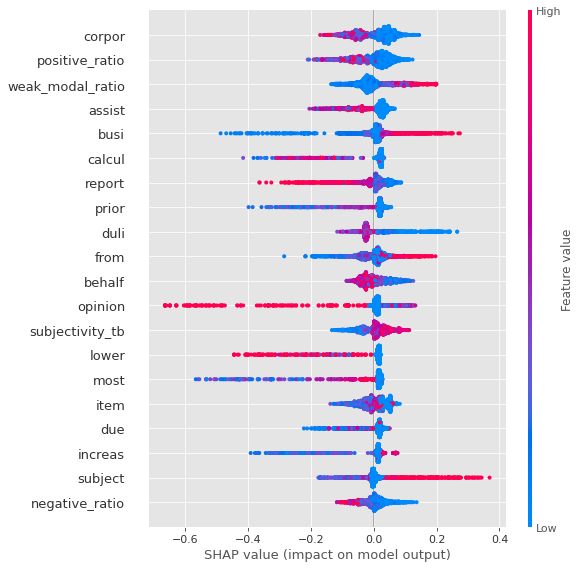

In [215]:
shap.summary_plot(shap_values_train, txt_dense_df)
